# DATA2 -  RF - baseline - Without standarization

## Features:
1. 'AGE'
1. 'Gender\_num\_'


1. 'RAVLT\_immediate'
1. 'AVDEL30MIN\_neuro'
1. 'AVDELTOT\_neuro'


1. 'TRAASCOR\_neuro'
1. 'TRABSCOR\_neuro'
1. 'CATANIMSC\_neuro'


1. 'LRHHC\_n\_long'
1. 'Apoe4_'


1. 'GDTOTAL\_gds'
1. 'ANARTERR\_neuro'



1. 'Subgroup\_'
1. 'Subgroup\_num\_'
1. 'Usage\_'


---

**Resources**
1. DATA
    1. [data/data2](https://github.com/MMIV-ML/MCI-subgroups/tree/master/data/data2) - csv files downloaded from ADNI,
    1. [data/data2_FS](https://github.com/MMIV-ML/MCI-subgroups/tree/master/data/data2_FS) - FS result csv files,
    1. [data_zip/20201109_data2_file_versions](https://github.com/MMIV-ML/MCI-subgroups/blob/master/data/data_zip/20201109_data2_file_versions.pdf) - download ADNI web page screen shoot taken for downaloaded csv files (some of file neames are printed with dates),
1. RESULTS
    1. [results/20210420](https://github.com/MMIV-ML/MCI-subgroups/tree/master/results/20210420) - result folder,
    1. [results/202100420/README.md](https://github.com/MMIV-ML/MCI-subgroups/blob/master/results/20210420/README.md) - short description,
1. GOOGLE DRIVE
    1. [slides](https://docs.google.com/presentation/d/1aEK7M5BPe0RxWYskzQCEDbT4Mf-4mRRqQ5uJ_YuqRzg/edit#slide=id.p) - link to google slides (**OUT OF DATE, MUST BE UPDATED !!!**),
    1. [GoogleDrive](https://drive.google.com/drive/folders/1r8l2R88-0T8Xahk30iAgjBCWXvV1R2J-) - the main google drive slide folder,
1. GIT HUB
    1. [GitHub](https://github.com/MMIV-ML/MCI-subgroups) - the main repo folder,
1. [An overview](https://github.com/MMIV-ML/MCI-subgroups/blob/master/results/20210420/3.xx_RF_bl_comparison.pdf)


The latest changes (ver. 0.16):

    v 0.16
    
        - save, load `train` and `val` test split from a file. For a different fold number e.g. k={10, 20, 50, ...}
        
    v 0.15
    
    - feature perumtation function from scratch -> moved to the separate notebook: 3.02-data2-RF-bl-permutation.ipynb,
    - Conf_mat_ results (TP, TN, FP, FN), -> saved to external csv files,
    - Replace manual CV scores with built-in functions,
    - CV folds split loaded from file (to use in `bl` and `long`).
    
   *Created: 2021.03.18 / Updated: 2021.10.07*
   
---

#### IMPORTS

In [88]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [89]:
import eli5
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
from pdpbox import pdp
import matplotlib.pyplot as plt

from pathlib import Path
from IPython.display import Image
from IPython.display import SVG #display, 
from eli5.sklearn import PermutationImportance

In [90]:
import mci_info as minfo
import mci_utils as mutils
# import mci_freesurfer as mfs
import mci_rf_bl as mrfbl

In [91]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import plot_partial_dependence

#### GLOBAL PATH VARIABLES

In [92]:
# Notebook folder
NB_DIR = %pwd
NB_DIR = Path(NB_DIR)
# Root MCI foler
ROOT_DIR = NB_DIR.parent
# Main data folder (with downloaded csv files)
MAIN_DATA_DIR = ROOT_DIR/'data/data2'
DATA_DIR_FS = ROOT_DIR / 'data/data2_FS'
# Current data dir with sMCI_cAD.csv & bl.csv files
CURRENT_DATA_DIR = ROOT_DIR/'results/20201110'
# Results folder
RESULTS_DIR = ROOT_DIR/'results/20211111' #misclassified patient table
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

#### INSTALLED PACKAGES INFO

In [93]:
if 1:
    packages = ['numpy', 'scipy', 'seaborn', 'pandas', 'matplotlib', 'statsmodels',
                'ipywidgets', 'eli5', 'pdpbox', 'sklearn']
    display(mutils.package_versions(installedOnly=False, theMostImportant=packages))



Computer name: MMIV-ML-Alienware-m17
Operating system: Linux, 64bit

Python path: /home/ingrid/miniconda3/envs/mci/bin/python
Python version: 3.9.7 | packaged by conda-forge | (default, Sep 29 2021, 19:20:46) 
[GCC 9.4.0]



module version
4          eli5  0.11.0
6    ipywidgets   7.6.5
10   matplotlib   3.4.3
13        numpy  1.21.3
15       pandas   1.3.4
16       pdpbox   0.2.1
20        scipy   1.7.1
21      seaborn  0.11.2
23      sklearn   1.0.1
24  statsmodels  0.13.0

---

## GLOBAL VARIABLES TO UPDATE IN EACH NOTEBOOK SEPARATELY!!! 

In [94]:
# features to feed the current model
FEATURES = ['AGE','RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro',
            'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro',
            'GDTOTAL_gds','ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_',
            'Subgroup_', 'Subgroup_num_', 'Usage_',
           'Gender_num_'
           ]
FEATURE_NUMBER=len(FEATURES)
print(f'Number of selected features: {FEATURE_NUMBER}')


# Filename prefixes used to save all results (tables, images, ...)
FILE_NAME_PREFIX = '3.12_RF'
FILE_NAME_NUMBER = FILE_NAME_PREFIX.split('_')[0]

# Filename to load/save model. 
#Used if we load model from file with different name.
FILE_NAME_WITH_GS_MODEL_TO_LOAD = '3.12_RF-master'
# For model name the same as the current file prefix
# FILE_NAME_WITH_GS_MODEL_TO_LOAD = FILE_NAME_PREFIX

# random state
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# folds 
FOLDS = 10
# cross-validation fold split number to save in a csv file
FOLDS_LIST = [10, 20, 50]

# display all stuff
VERBOSE = True

Number of selected features: 15


---

## LOAD `CSV BASELINE` FILE

Load baseline csv file and restrict the whole bunch of avaliable features to those defined in the variable `FEATURES` that is defined above.

In [95]:
bl_name = CURRENT_DATA_DIR / 'bl.csv'
bl_loaded = pd.read_csv(bl_name, index_col=0)

bl_sel_feat = bl_loaded[FEATURES]

print(f'Subjects: \t{bl_sel_feat.shape[0]}')
print(f'Columns: \t{bl_sel_feat.shape[1]}')

Subjects: 	708
Columns: 	15


#### DISPLAY THE NAN VALUES IN THE WHOLE DATA FRAME

Insepect `NaN` values in the loaded dataframe.

In [96]:
if VERBOSE:
    print(bl_sel_feat.isnull().sum())
    bl_sel_feat.shape

AGE                  0
RAVLT_immediate      0
AVDEL30MIN_neuro     0
AVDELTOT_neuro       1
TRAASCOR_neuro       0
TRABSCOR_neuro      10
CATANIMSC_neuro      0
GDTOTAL_gds          0
ANARTERR_neuro       6
LRHHC_n_long        14
Apoe4_               0
Subgroup_            0
Subgroup_num_        0
Usage_               0
Gender_num_          0
dtype: int64


### SPLIT BETWEEN TRAIN AND TEST SUBSETS

In [97]:
bl_train = bl_sel_feat.loc[bl_sel_feat.Usage_ == 'train']
bl_test = bl_sel_feat.loc[bl_sel_feat.Usage_ == 'test']

# a list of both sets, to ease further manipulation
bl_sets = [['Train set', bl_train], ['Test set', bl_test]]

---

## TRAIN / TEST SETS SHORT INFO

In [98]:
if VERBOSE: 
    print('Subjects in:')
    for name, bl in bl_sets:
        print(f'\t{name}:\t{bl.shape[0]} ({bl.shape[0]/bl_sel_feat.shape[0] * 100:.0f}%)')

    print('\n\nSubjects in each subgroup (with NaN included):\n')
    for name, bl in bl_sets:
        print(f'*** {name} ***\n{bl.Subgroup_.value_counts().to_string()}\n')

Subjects in:
	Train set:	566 (80%)
	Test set:	142 (20%)


Subjects in each subgroup (with NaN included):

*** Train set ***
sMCI    305
cAD     261

*** Test set ***
sMCI    76
cAD     66



#### PRINT COLUMN NAMES INCLUDED IN BOTH SETS

In [99]:
minfo.included_feature_info(bl_train, pattern='adni-neuro-gds-long-_')

Total number of columns: 15



adni (#2)        neuro (#6)     gds (#1)     long (#1)      ours (#5)
0              AGE    ANARTERR_neuro  GDTOTAL_gds  LRHHC_n_long         Apoe4_
1  RAVLT_immediate  AVDEL30MIN_neuro                               Gender_num_
2                     AVDELTOT_neuro                                 Subgroup_
3                    CATANIMSC_neuro                             Subgroup_num_
4                     TRAASCOR_neuro                                    Usage_
5                     TRABSCOR_neuro

---

## COUNT `NaN` VALUES IN TRAIN AND TEST SETS

In [100]:
if VERBOSE:
    for name, bl in bl_sets:        
        print(f'*** NaN values in {name.upper()} set (out of {bl.shape[0]} rows) ***')
        print(bl.isnull().sum().to_string())
        print(f'\nRows in {name}: {bl.shape[0]}')
        print('\n\n')

*** NaN values in TRAIN SET set (out of 566 rows) ***
AGE                  0
RAVLT_immediate      0
AVDEL30MIN_neuro     0
AVDELTOT_neuro       1
TRAASCOR_neuro       0
TRABSCOR_neuro      10
CATANIMSC_neuro      0
GDTOTAL_gds          0
ANARTERR_neuro       4
LRHHC_n_long        13
Apoe4_               0
Subgroup_            0
Subgroup_num_        0
Usage_               0
Gender_num_          0

Rows in Train set: 566



*** NaN values in TEST SET set (out of 142 rows) ***
AGE                 0
RAVLT_immediate     0
AVDEL30MIN_neuro    0
AVDELTOT_neuro      0
TRAASCOR_neuro      0
TRABSCOR_neuro      0
CATANIMSC_neuro     0
GDTOTAL_gds         0
ANARTERR_neuro      2
LRHHC_n_long        1
Apoe4_              0
Subgroup_           0
Subgroup_num_       0
Usage_              0
Gender_num_         0

Rows in Test set: 142





#### DISPLAY ALL SUBJECTS THAT CONTAIN `NaN` VALUES (BOTH SETS)

In [101]:
if VERBOSE:
    for name, bl in bl_sets:
        num = bl.isnull().sum().sum()
        #idx = bl.isnull().index
        print(f'*** {name.upper()} ***')
        display(bl.loc[bl.isnull().any(axis=1)].head(num))
        print()

*** TRAIN SET ***


AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  TRAASCOR_neuro  \
0     67.5             37.0               7.0            13.0            67.0   
20    83.3             21.0               0.0             7.0            34.0   
2284  69.0             29.0               1.0            11.0            54.0   
2948  61.7             21.0               0.0             6.0            57.0   
3367  65.5             20.0               4.0            12.0            26.0   
3437  75.2             27.0               3.0            10.0            22.0   
3523  81.6             28.0               3.0            10.0            61.0   
3547  76.6             33.0               8.0            14.0            40.0   
3639  66.7             55.0              11.0            14.0            33.0   
3652  71.0             20.0               0.0             8.0            60.0   
3855  76.6             38.0               7.0            15.0            39.0   
3883  56.3             53.0               9.0            15.0            30.0   
4133  68.9             47.0               8.0            11.0            23.0   
4153  86.4             17.0               2.0             7.0            72.0   
4484  69.4             38.0               5.0             9.0            49.0   
4713  71.9             42.0               4.0            15.0            28.0   
4814  76.8             39.0               7.0            14.0            30.0   
4913  71.3             44.0               0.0             NaN            28.0   
4930  68.1             54.0              13.0            15.0            27.0   
5077  77.6             26.0               3.0             7.0            53.0   
5353  79.3             25.0               0.0             3.0            38.0   
5530  65.4             34.0               2.0            15.0            41.0   
5831  71.9             28.0               5.0            11.0            36.0   
5855  85.3             24.0               3.0             8.0            72.0   
5978  55.0             42.0               7.0            13.0            23.0   
6111  75.3             18.0               0.0            13.0            56.0   
6140  69.0             29.0               0.0             4.0            27.0   

      TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  ANARTERR_neuro  \
0              271.0             22.0          3.0             NaN   
20               NaN             16.0          2.0             2.0   
2284             NaN             11.0          5.0            34.0   
2948             NaN             10.0          2.0            25.0   
3367            75.0             14.0          1.0             NaN   
3437           112.0             22.0          0.0            14.0   
3523           170.0             14.0          0.0            24.0   
3547             NaN             13.0          3.0             3.0   
3639             NaN             28.0          3.0             1.0   
3652           176.0             20.0          1.0            24.0   
3855            82.0             13.0          1.0             NaN   
3883             NaN             24.0          4.0            20.0   
4133            50.0             17.0          2.0            26.0   
4153           300.0              5.0          5.0            38.0   
4484             NaN             18.0          1.0             5.0   
4713            91.0             20.0          1.0             3.0   
4814             NaN             22.0          3.0            27.0   
4913            45.0             20.0          1.0             2.0   
4930            65.0             17.0          0.0             4.0   
5077           180.0             23.0          5.0            27.0   
5353           120.0             17.0          4.0            14.0   
5530            67.0             11.0          3.0            14.0   
5831             NaN             21.0          0.0             6.0   
5855           298.0             11.0          2.0        


*** TEST SET ***


AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  TRAASCOR_neuro  \
3926  63.0             32.0               5.0            15.0            35.0   
6291  71.5             34.0               7.0            13.0            50.0   
6304  80.2             25.0               0.0            10.0            31.0   

      TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  ANARTERR_neuro  \
3926           105.0             21.0          2.0             7.0   
6291           127.0             16.0          1.0             NaN   
6304            73.0              8.0          1.0             NaN   

      LRHHC_n_long  Apoe4_ Subgroup_  Subgroup_num_ Usage_  Gender_num_  
3926           NaN     1.0      sMCI              0   test            0  
6291      0.004996     0.0      sMCI              0   test            0  
6304      0.003878     0.0       cAD              1   test            1

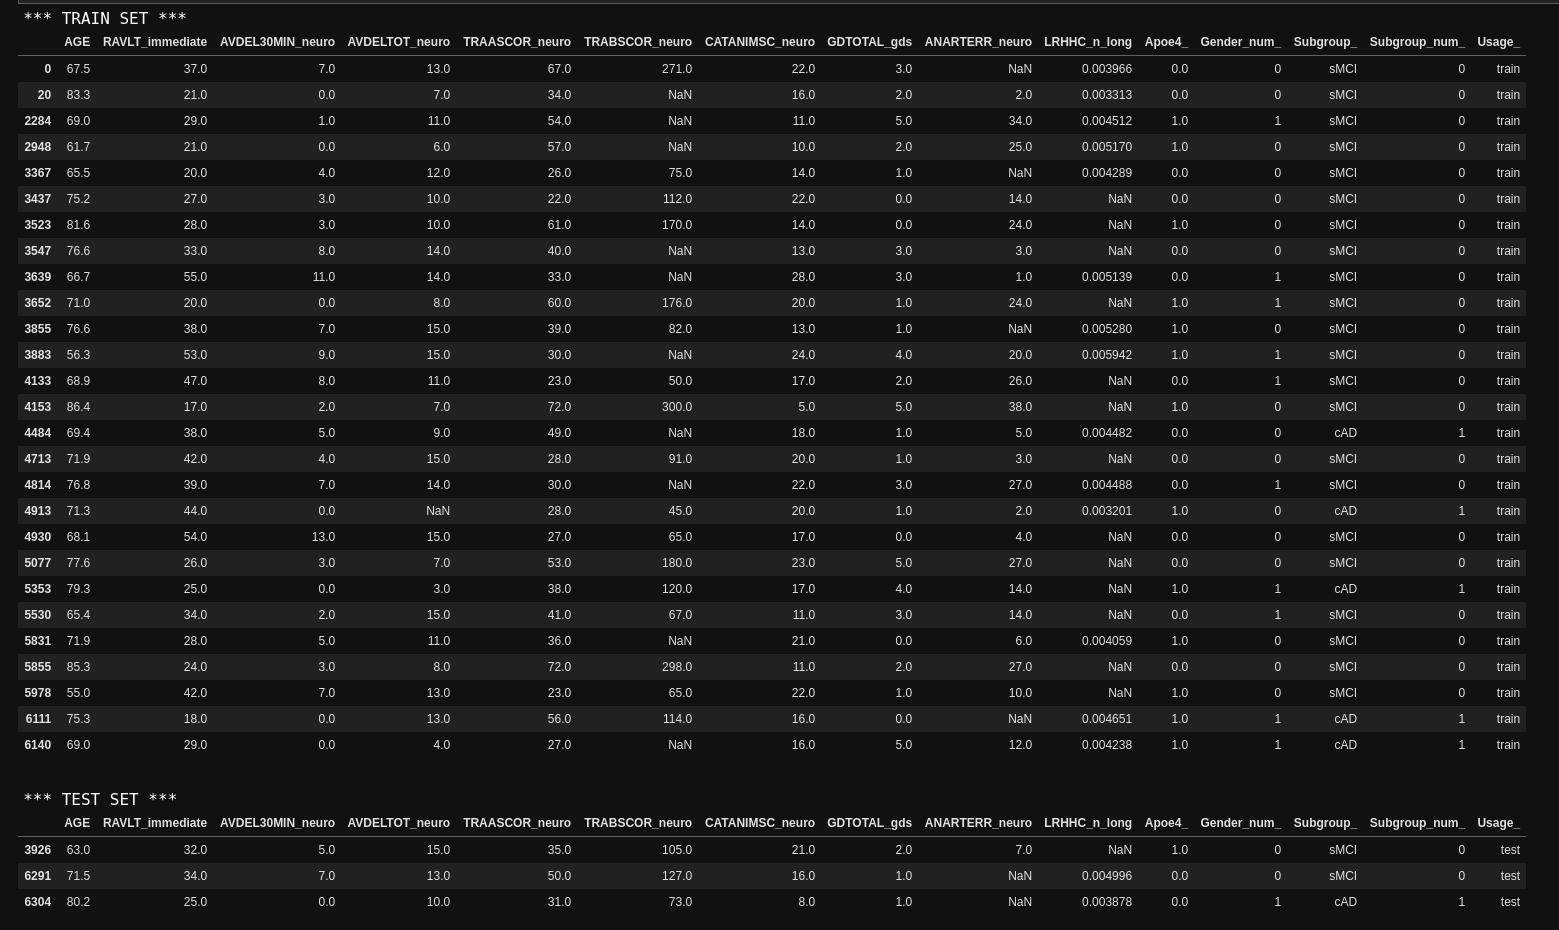

In [102]:
if VERBOSE:
    display(Image(filename="figs/assets/NaN_subjects.png", width=900))

## DROP `NaN` VALUES IN TRAIN AND TEST SETS (IF ANY)

In [103]:
print('\nSubjects number in both sets AFTER dropping NaN values:\n')
for name, bl in bl_sets:        
    bl.dropna(axis='rows', inplace=True)
    print(f' - {name}: {bl.shape[0]}\n')


Subjects number in both sets AFTER dropping NaN values:

 - Train set: 539

 - Test set: 139



#### COUNT `NaN` VALUES IN TRAIN AND TEST SETS (AFTER DROP `NaN` ROWS) 

In [104]:
if VERBOSE:
    for name, bl in bl_sets:        
        print(f'*** NaN values in {name.upper()} set (out of {bl.shape[0]} rows) ***')
        print(bl.isnull().sum().to_string())
        print(f'\nRows in {name}: {bl.shape[0]}')
        print('\n\n')

*** NaN values in TRAIN SET set (out of 539 rows) ***
AGE                 0
RAVLT_immediate     0
AVDEL30MIN_neuro    0
AVDELTOT_neuro      0
TRAASCOR_neuro      0
TRABSCOR_neuro      0
CATANIMSC_neuro     0
GDTOTAL_gds         0
ANARTERR_neuro      0
LRHHC_n_long        0
Apoe4_              0
Subgroup_           0
Subgroup_num_       0
Usage_              0
Gender_num_         0

Rows in Train set: 539



*** NaN values in TEST SET set (out of 139 rows) ***
AGE                 0
RAVLT_immediate     0
AVDEL30MIN_neuro    0
AVDELTOT_neuro      0
TRAASCOR_neuro      0
TRABSCOR_neuro      0
CATANIMSC_neuro     0
GDTOTAL_gds         0
ANARTERR_neuro      0
LRHHC_n_long        0
Apoe4_              0
Subgroup_           0
Subgroup_num_       0
Usage_              0
Gender_num_         0

Rows in Test set: 139





___

#### COUNT TRAIN / TEST  PERCENTAGE PROPORTION AFTER EXCLUDING NaN VALUES

In [108]:
print('Subjects in:')
for name, bl in bl_sets:
    print(f'\t{name}:\t{bl.shape[0]} ({bl.shape[0]/(bl_train.shape[0] + bl_test.shape[0]) * 100:.0f}%)')

print('\n\nSubjects in each subgroup (without NaN included):\n')
for name, bl in bl_sets:
    #print(f'*** {name} ***\n')
    mutils.textWrap(name)
    print()
    #print(f'{bl.Subgroup_.value_counts().to_string()}\n')
    #print(f'{bl.PTGENDER.value_counts().to_string()}\n')
    
    dfs = bl.Subgroup_.value_counts().rename_axis('Subgroup_').reset_index(name='#Nr')
    dfp = bl.PTGENDER.value_counts().rename_axis('PTGENDER').reset_index(name='#Nr')
    df = pd.concat([dfs,dfp],axis=1)
    display(df)
    

    cols1 = ['AGE']
    cols2 = ['PTGENDER'] 
    df1 = bl.groupby(['Subgroup_', 'PTGENDER'])
    a = df1[cols1].mean().round(2)
    c = df1[cols1].std().round(2)
    b = df1[cols2].count()
    
    df_abc = pd.concat([a,c,b],axis=1) 
    display(df_abc)

Subjects in:
	Train set:	539 (79%)
	Test set:	139 (21%)


Subjects in each subgroup (without NaN included):


#################
### Train set ###
#################



AttributeError: 'DataFrame' object has no attribute 'PTGENDER'

### SOME `SUBGROUP\_` STATISTICS

In [109]:
if VERBOSE:
    print('Basic statistics for features in both sets:')
    for name, bl in bl_sets:
        mutils.textWrap(name)
        print(f'\nSubjects {bl.shape[0]}')
        
        for gr in ['sMCI', 'cAD']:
            print(f'\n*** {gr} ***')
            display(minfo.df_stats_info(bl[bl.Subgroup_ == gr]))

Basic statistics for features in both sets:

#################
### Train set ###
#################

Subjects 539

*** sMCI ***


max.     mean    min.     std  val_range  NaN_Nr
AGE                91.400   73.223  55.900   7.493     35.500       0
RAVLT_immediate    67.000   36.905  13.000  10.855     54.000       0
AVDEL30MIN_neuro   15.000    4.947   0.000   3.994     15.000       0
AVDELTOT_neuro     15.000   11.219   0.000   3.178     15.000       0
TRAASCOR_neuro    148.000   39.445  13.000  16.360    135.000       0
TRABSCOR_neuro    300.000  109.721  33.000  59.687    267.000       0
CATANIMSC_neuro    32.000   17.710   5.000   5.222     27.000       0
GDTOTAL_gds         6.000    1.678   0.000   1.473      6.000       0
ANARTERR_neuro     50.000   13.085   0.000   9.343     50.000       0
LRHHC_n_long        0.006    0.005   0.003   0.001      0.004       0
Apoe4_              1.000    0.424   0.000   0.495      1.000       0
Subgroup_num_       0.000    0.000   0.000   0.000      0.000       0
Gender_num_         1.000    0.406   0.000   0.492      1.000       0


*** cAD ***


max.     mean    min.     std  val_range  NaN_Nr
AGE                88.300   73.916  55.200   6.964     33.100       0
RAVLT_immediate    67.000   28.957  11.000   7.885     56.000       0
AVDEL30MIN_neuro   15.000    1.957   0.000   2.669     15.000       0
AVDELTOT_neuro     15.000    9.324   0.000   3.551     15.000       0
TRAASCOR_neuro    150.000   44.887  17.000  19.970    133.000       0
TRABSCOR_neuro    300.000  134.043  40.000  72.146    260.000       0
CATANIMSC_neuro    35.000   15.836   5.000   4.882     30.000       0
GDTOTAL_gds         6.000    1.707   0.000   1.424      6.000       0
ANARTERR_neuro     48.000   13.336   0.000   9.557     48.000       0
LRHHC_n_long        0.006    0.004   0.002   0.001      0.004       0
Apoe4_              1.000    0.637   0.000   0.482      1.000       0
Subgroup_num_       1.000    1.000   1.000   0.000      0.000       0
Gender_num_         1.000    0.391   0.000   0.489      1.000       0


################
### Test set ###
################

Subjects 139

*** sMCI ***


max.     mean    min.     std  val_range  NaN_Nr
AGE                87.800   72.861  57.800   7.340     30.000       0
RAVLT_immediate    65.000   36.838  20.000   9.223     45.000       0
AVDEL30MIN_neuro   14.000    4.622   0.000   3.670     14.000       0
AVDELTOT_neuro     15.000   11.405   1.000   3.114     14.000       0
TRAASCOR_neuro     87.000   38.149  16.000  12.059     71.000       0
TRABSCOR_neuro    283.000  101.892  54.000  44.779    229.000       0
CATANIMSC_neuro    30.000   18.176   6.000   5.005     24.000       0
GDTOTAL_gds         5.000    1.824   0.000   1.286      5.000       0
ANARTERR_neuro     43.000   11.973   0.000   9.223     43.000       0
LRHHC_n_long        0.007    0.004   0.003   0.001      0.004       0
Apoe4_              1.000    0.419   0.000   0.497      1.000       0
Subgroup_num_       0.000    0.000   0.000   0.000      0.000       0
Gender_num_         1.000    0.432   0.000   0.499      1.000       0


*** cAD ***


max.     mean    min.     std  val_range  NaN_Nr
AGE                88.400   73.875  55.000   7.729     33.400       0
RAVLT_immediate    50.000   30.800  20.000   6.911     30.000       0
AVDEL30MIN_neuro   11.000    2.400   0.000   2.656     11.000       0
AVDELTOT_neuro     15.000    9.785   2.000   3.586     13.000       0
TRAASCOR_neuro    150.000   44.200  21.000  26.764    129.000       0
TRABSCOR_neuro    300.000  132.785  38.000  81.064    262.000       0
CATANIMSC_neuro    28.000   15.877   6.000   4.204     22.000       0
GDTOTAL_gds         4.000    1.431   0.000   1.199      4.000       0
ANARTERR_neuro     44.000   13.169   0.000  10.080     44.000       0
LRHHC_n_long        0.006    0.004   0.003   0.001      0.003       0
Apoe4_              1.000    0.662   0.000   0.477      1.000       0
Subgroup_num_       1.000    1.000   1.000   0.000      0.000       0
Gender_num_         1.000    0.385   0.000   0.490      1.000       0



---

# CREATE X AND y

___

In [110]:
# train set
X_train = bl_train.copy(deep=True)
y_train = X_train.Subgroup_num_

# test set
X_test = bl_test.copy(deep=True)
y_test = X_test.Subgroup_num_

# a list of both sets, to ease forfurther manipulation
X_sets = [['X train set', X_train], ['X test set', X_test]]
y_sets = [['y train set', y_train], ['y test set', y_test]]

In [111]:
print(X_test.shape)
print(X_train.shape)


(139, 15)
(539, 15)


# SAVING FOR PYCHARET #

In [23]:
pycharet = pd.concat([X_train, X_test])
print(pycharet.shape)
pycharet.to_csv(RESULTS_DIR / '3.12_pycharet.csv')

(678, 15)


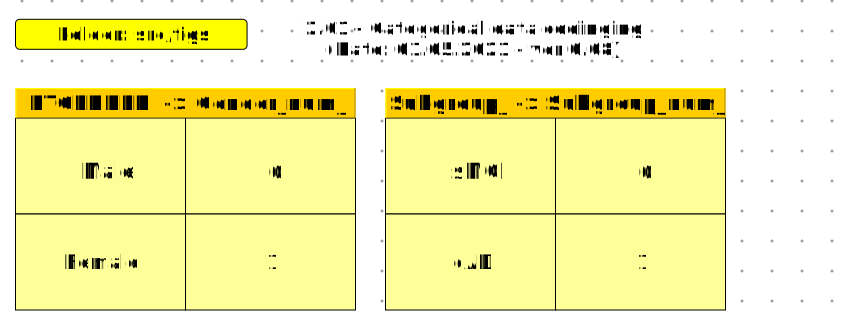

In [112]:
SVG(filename='figs/2.01_preprocessing_categorical_2_num.svg')

___

# PREPARE `CROSS-VALIDATION` FOLDS FOR FUTURES USE (E.G. WITH LONGITUDINAL DATA)

### SAVE `CROSS-VALIDATION` FOLDS TO A `CSV` FILE

To have the same split rules for `bl` and `long` analysies we prepare a csv file with splits between `train` and `test` sets for varius k, e.g. for `k={10,20,50}`.

In [113]:
save_kfolds = 1

if save_kfolds:
    df2 = pd.DataFrame(index=X_train.index)
    #df2['X_train_idx'] = X_train.index
    
    for fld in FOLDS_LIST:
        # prefix: SKF_
        skf = StratifiedKFold(n_splits=fld, shuffle=False)
        SPLITS = []

        # a table for each fold separately (10...20...50)
        df = pd.DataFrame(index=X_train.index)
        
        
        for k, (train_index, validation_index) in enumerate(skf.split(X_train,y_train)):
        #     X_trainCV, X_validCV = X_train.iloc[train_index,:], X_train.iloc[validation_index,:]
        #     y_trainCV, y_validCV = y_train.iloc[train_index], y_train.iloc[validation_index]
            SPLITS.append([train_index, validation_index])
            
            col_name = f'SKF_CV{fld}_F{k:0>2}_'
            df.loc[X_train.index[validation_index], col_name] = "val"
            df.loc[X_train.index[train_index], col_name] = "train"
            
        # a table to concatenate tables with folds -> concat([df10, df20, df50])
        df2 = pd.concat([df2,df], axis=1)  
    
    # save to a file
    kfolds_csv_path = RESULTS_DIR / f'{FILE_NAME_PREFIX}_kfolds.csv'
    df2.to_csv(kfolds_csv_path)
    print(f'File saved to\n\t{kfolds_csv_path}')
    print()

File saved to
	/home/ingrid/123/results/20211111/3.12_RF_kfolds.csv



#### LOAD `CROSS-VALIDATION` FOLDS FROM FILE

In [114]:
kfolds_csv_path = RESULTS_DIR / f'{FILE_NAME_PREFIX}_kfolds.csv'
SPLITS = mutils.load_train_val_cv_splits_from_file(kfolds_csv_path, FOLDS)  

print(f"test\tval.\ttotal\n{25*'-'}")
for k in range(len(SPLITS)):
    #             #train, #val, #sum
    print(f'{len(SPLITS[k][0])}\t{len(SPLITS[k][1])}\t{len(SPLITS[k][0])+len(SPLITS[k][1])}')

test	val.	total
-------------------------
485	54	539
485	54	539
485	54	539
485	54	539
485	54	539
485	54	539
485	54	539
485	54	539
485	54	539
486	53	539


---

# RANDOM FORESTS CLASSIFICATION

___

## REMOVE SELECTED COLUMNS FROM THE TRAIN & TEST SETS

## Commet Rye: This is the place to choose whether gender should be included. If I add 'Gender_num_' here then also this features is removed from the model. 

In [115]:
print('From:')
for name, X in X_sets:
    print(f'\t{name}')
    
    for feat in ['Subgroup_', 'Subgroup_num_', 'Usage_', 'PTGENDER']:
        if feat in X.columns: X.drop(columns=feat,inplace=True); print(f'\t\tRemoved: {feat}')

From:
	X train set
		Removed: Subgroup_
		Removed: Subgroup_num_
		Removed: Usage_
	X test set
		Removed: Subgroup_
		Removed: Subgroup_num_
		Removed: Usage_


In [116]:
print('Column names in:\n')
for name, X in X_sets:
    print(f'- {name}:\n  {X.columns.to_list()}\n')

Column names in:

- X train set:
  ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_', 'Gender_num_']

- X test set:
  ['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_', 'Gender_num_']



#### BASIC STATISTISC OF FEATURES IN TRAIN AND TEST SETS

In [117]:
if VERBOSE:
    print('Basic statistics for features in both sets:')
    for name, X in X_sets:
        print(f'\n{name} (Subjects {X.shape[0]}):')
        display(minfo.df_stats_info(X, precision=2))

Basic statistics for features in both sets:

X train set (Subjects 539):


max.    mean  min.    std  val_range  NaN_Nr
AGE                91.40   73.55  55.2   7.25       36.2       0
RAVLT_immediate    67.00   33.13  11.0  10.34       56.0       0
AVDEL30MIN_neuro   15.00    3.53   0.0   3.74       15.0       0
AVDELTOT_neuro     15.00   10.32   0.0   3.49       15.0       0
TRAASCOR_neuro    150.00   42.03  13.0  18.35      137.0       0
TRABSCOR_neuro    300.00  121.27  33.0  66.95      267.0       0
CATANIMSC_neuro    35.00   16.82   5.0   5.14       30.0       0
GDTOTAL_gds         6.00    1.69   0.0   1.45        6.0       0
ANARTERR_neuro     50.00   13.20   0.0   9.44       50.0       0
LRHHC_n_long        0.01    0.00   0.0   0.00        0.0       0
Apoe4_              1.00    0.53   0.0   0.50        1.0       0
Gender_num_         1.00    0.40   0.0   0.49        1.0       0


X test set (Subjects 139):


max.    mean  min.    std  val_range  NaN_Nr
AGE                88.40   73.34  55.0   7.51       33.4       0
RAVLT_immediate    65.00   34.01  20.0   8.73       45.0       0
AVDEL30MIN_neuro   14.00    3.58   0.0   3.41       14.0       0
AVDELTOT_neuro     15.00   10.65   1.0   3.43       14.0       0
TRAASCOR_neuro    150.00   40.98  16.0  20.45      134.0       0
TRABSCOR_neuro    300.00  116.34  38.0  65.94      262.0       0
CATANIMSC_neuro    30.00   17.10   6.0   4.77       24.0       0
GDTOTAL_gds         5.00    1.64   0.0   1.26        5.0       0
ANARTERR_neuro     44.00   12.53   0.0   9.62       44.0       0
LRHHC_n_long        0.01    0.00   0.0   0.00        0.0       0
Apoe4_              1.00    0.53   0.0   0.50        1.0       0
Gender_num_         1.00    0.41   0.0   0.49        1.0       0

---

# GRID SEARCH (PERFORM  OR LOAD)

In [118]:
# Run gridsearch (if grid_search=1) and save the model to a file
# Load the best model from the file (if grid_search = 0)
grid_search = 0

# A filename of the the whole gridsearch structure
file_name_prefix_ext = FILE_NAME_WITH_GS_MODEL_TO_LOAD + '-GS-model.pkl'
file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext

# define a stratification sheme
skf = StratifiedKFold(n_splits=FOLDS, shuffle=False)

if grid_search:       
    print("Searching the best RF's parameters...")
    rfcl = RandomForestClassifier(random_state=RANDOM_STATE)

    params = {"n_estimators": [40, 60, 70, 75, 80, 85, 90, 100, 120, 500, 1000, 10000],
              "max_depth": [3, 4, 5, 6],
              "max_features": [2, 3, 4, 5],
              "min_samples_split": [1, 2, 3],
              "min_samples_leaf": [1, 2, 3],
              "bootstrap": [True, False],
              "criterion": ["gini", 'entropy']}    
    #params = {"n_estimators": [100, 373, 374, 375,1000, 10000]}
    
    grid = GridSearchCV(estimator=rfcl, param_grid=params, verbose=1, refit='accuracy', cv=skf, n_jobs=32, 
                       scoring = ['accuracy', 'f1', 'precision', 'recall'])
    
    # fit the best estimator to the train data
    grid.fit(X_train, y_train)
    
    # save best estimator to the file
    joblib.dump(grid, file_name_prefix_path)     
    print(f'Saved GridSearch object to: {file_name_prefix_path}')
else:
    print(f"GridSearch parameters loaded from a file:\n\t\t{file_name_prefix_path}")
    grid = joblib.load(file_name_prefix_path)     

    
clf = grid.best_estimator_

print()
print(f'Best score: {grid.best_score_:.3f}\n')

print(f'Best params:')
for k,v in grid.best_params_.items():
    print(f'\t{k}: {v}')
    
# save best params to a global variable
print('Best params are stored in BEST_PARAMS variable!!!')
BEST_PARAMS = grid.best_params_


#print(grid.cv_results_)
# for k in metrics.SCORERS.keys():
#     print(k)

GridSearch parameters loaded from a file:
		/home/ingrid/123/results/20211111/3.12_RF-master-GS-model.pkl

Best score: 0.742

Best params:
	bootstrap: True
	criterion: entropy
	max_depth: 4
	max_features: 4
	min_samples_leaf: 2
	min_samples_split: 2
	n_estimators: 75
Best params are stored in BEST_PARAMS variable!!!


In [119]:
BEST_PARAMS

{'bootstrap': True,
 'criterion': 'entropy',
 'max_depth': 4,
 'max_features': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 75}

___

# A PIPELINE WITH ESTABLISHED RF PARAMETERS (AFTER GRID SEARCH) 

---

## CV10 SCORES (F1, ACCURACY, REACALL, PRECISION)

In [120]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
scores_cv = cross_validate(clf, X_train, y_train, cv=SPLITS, scoring=['accuracy', 'f1', 'recall', 'precision'])

scores_cv_df = pd.DataFrame(scores_cv)
scores_cv_df = scores_cv_df[['test_accuracy', 'test_f1', 'test_recall', 'test_precision']]
scores_cv_df.rename(columns = {'test_accuracy': 'acc', 'test_f1':'f1',
                               'test_recall':'recall', 'test_precision':'prec'}, inplace=True)
display(scores_cv_df)

acc        f1    recall      prec
0  0.648148  0.666667  0.730769  0.612903
1  0.703704  0.724138  0.807692  0.656250
2  0.740741  0.766667  0.884615  0.676471
3  0.759259  0.786885  0.923077  0.685714
4  0.888889  0.884615  0.884615  0.884615
5  0.796296  0.792453  0.807692  0.777778
6  0.629630  0.565217  0.520000  0.619048
7  0.777778  0.760000  0.760000  0.760000
8  0.814815  0.782609  0.720000  0.857143
9  0.660377  0.678571  0.760000  0.612903

### Mean score values for crossvalidation (k=10 folds):

In [121]:
prec = 2
score_all_folds_mean_df = pd.DataFrame.from_dict({'mean':scores_cv_df.mean().round(prec),
                                                  'std.':scores_cv_df.std().round(prec+1),
                                                  'min.':scores_cv_df.min().round(prec),
                                                  'max.':scores_cv_df.max().round(prec),
                                                  'range':scores_cv_df.values.ptp(axis=0).round(prec)})
display(score_all_folds_mean_df)

mean   std.  min.  max.  range
acc     0.74  0.082  0.63  0.89   0.26
f1      0.74  0.087  0.57  0.88   0.32
recall  0.78  0.115  0.52  0.92   0.40
prec    0.71  0.100  0.61  0.88   0.27

----

In [122]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)


feat_import_CV = pd.DataFrame(index=X_train.columns, columns=list(range(FOLDS)))
conf_matrix_CV = np.zeros((FOLDS, 2 ,2))
valid_set_len_CV = np.ones(FOLDS)  # to calculate mean validation test lenght
bl_CV_pred_all = pd.DataFrame()


for k, (train_index, validation_index) in enumerate(SPLITS):
    X_trainCV, X_validCV = X_train.iloc[train_index,:], X_train.iloc[validation_index,:]
    y_trainCV, y_validCV = y_train.iloc[train_index], y_train.iloc[validation_index]
      
    # MODEL    
    # fit
    clf.fit(X_trainCV, y_trainCV)
    # predict
    y_predCV= clf.predict(X_validCV).reshape(-1,)
    
    # METRICS
    # confusion matrix for all folds
    conf_matrix_CV[k, :, :]  = metrics.confusion_matrix(y_validCV, y_predCV)    
    # feature importance for all folds
    feat_import_CV[k] = clf.feature_importances_
    
    # CONFUSION MATRIX coefficients
    X_validCV_extended = mrfbl.confusion_matrix_coefficients_TPTNFPFN(X_validCV, y_validCV, y_predCV)
    
    # additional info about the current fold
    X_validCV_extended[f'CV{FOLDS}F_'] = k
    X_validCV_extended[f'CV{FOLDS}_Usage_'] = 'valid' 
    
    # df to agregate confusion-matrix-coefficients from all folds
    bl_CV_pred_all = pd.concat([bl_CV_pred_all, X_validCV_extended], axis=0)     
    
    # df with MISCLASSIFIED subjects in the current fold (k)
    err = X_validCV_extended.loc[(X_validCV_extended.y_true_ != X_validCV_extended.y_pred_)]
    print(f'fold: {k}, errors: {err.shape[0]}/{y_validCV.shape[0]}  ({err.shape[0]/y_validCV.shape[0]*100 :.1f}%)')
       
    # set current validation test set length
    valid_set_len_CV[k] = len(y_validCV)

fold: 0, errors: 19/54  (35.2%)
fold: 1, errors: 16/54  (29.6%)
fold: 2, errors: 14/54  (25.9%)
fold: 3, errors: 13/54  (24.1%)
fold: 4, errors: 6/54  (11.1%)
fold: 5, errors: 11/54  (20.4%)
fold: 6, errors: 20/54  (37.0%)
fold: 7, errors: 12/54  (22.2%)
fold: 8, errors: 10/54  (18.5%)
fold: 9, errors: 18/53  (34.0%)


In [123]:
#df_predictions_all.tail(3)

#### LINK PREDICTION TABLE WITH OTHER SUBJECT FEATURES

The predictions and all other subject features are stored in a `csv` file.

In [124]:
cols2 =[f'CV{FOLDS}F_',  f'CV{FOLDS}_Usage_'] 
filename = FILE_NAME_PREFIX + f'-CV{FOLDS}-predictions.csv'

bl_CV_pred_full = mrfbl.link_prediction_results_with_other_subject_features(bl_loaded, bl_CV_pred_all, cols2,
                                                                            filename, save=True, results_dir=RESULTS_DIR)


Subjects in the predictions table: 539

Predictions have been saved to a file:
		/home/ingrid/123/results/20211111/3.12_RF-CV10-predictions.csv


#### INTERACTIVE FOLDS INVESTIGATION (OPTIONAL)

In [125]:
if VERBOSE:
    cols = ['RID',  'y_true_', 'y_pred_', 'CM_pred_', f'CV{FOLDS}F_']
    minfo.iterate_patient_GUI(bl_CV_pred_full[cols], column=f'CV{FOLDS}F_')

---

# MODEL ANALYSIS & VISUALIZATION

---

## FEATURE IMPORTANCE (AVERAGE OUT OF 10 FOLDS)

In [126]:
feat_import_CV.reset_index(inplace=True)
feat_import_CV = feat_import_CV.rename({'index': 'feature'}, axis='columns')

#### FATURE IMPORTANCE IN EACH FOLD

In [127]:
if VERBOSE:
    display(feat_import_CV)

feature         0         1         2         3         4  \
0                AGE  0.053830  0.048757  0.050127  0.050570  0.058946   
1    RAVLT_immediate  0.285701  0.255642  0.254285  0.236905  0.257827   
2   AVDEL30MIN_neuro  0.165700  0.179112  0.175816  0.182719  0.163940   
3     AVDELTOT_neuro  0.038765  0.039334  0.043103  0.041862  0.047636   
4     TRAASCOR_neuro  0.061391  0.070749  0.060503  0.056689  0.060796   
5     TRABSCOR_neuro  0.051553  0.054241  0.068572  0.069446  0.057562   
6    CATANIMSC_neuro  0.045829  0.045248  0.048655  0.037206  0.054511   
7        GDTOTAL_gds  0.020585  0.013348  0.017594  0.012445  0.018358   
8     ANARTERR_neuro  0.040386  0.044753  0.041772  0.055750  0.050349   
9       LRHHC_n_long  0.184948  0.208380  0.206380  0.208825  0.191124   
10            Apoe4_  0.037445  0.026413  0.016196  0.035655  0.028897   
11       Gender_num_  0.013867  0.014023  0.016998  0.011928  0.010054   

           5         6         7         8         9  
0   0.057099  0.042339  0.053082  0.062831  0.048564  
1   0.275839  0.270740  0.236615  0.246002  0.203480  
2   0.169908  0.209821  0.201064  0.176701  0.221225  
3   0.049470  0.046902  0.038194  0.046417  0.042479  
4   0.055598  0.040370  0.053545  0.045231  0.054061  
5   0.065023  0.066074  0.081982  0.058628  0.064143  
6   0.047468  0.041872  0.043087  0.038579  0.041823  
7   0.016824  0.019728  0.011709  0.012079  0.017321  
8   0.050948  0.047788  0.053605  0.057566  0.049396  
9   0.157637  0.182658  0.192001  0.215108  0.217064  
10  0.032097  0.018779  0.023032  0.032388  0.031306  
11  0.022088  0.012930  0.012082  0.008471  0.009138

#### AVERAGE FEATURE IMPORTANCE OVER 10 FOLDS

In [128]:
feat_import_CV_stats = pd.DataFrame.from_dict({'feature':feat_import_CV.feature, 'mean':feat_import_CV.mean(axis=1).round(2), 'std.':feat_import_CV.std(axis=1).round(2)})
feat_import_CV_stats.sort_values(by='mean',ascending=False)

feature  mean  std.
1    RAVLT_immediate  0.25  0.02
9       LRHHC_n_long  0.20  0.02
2   AVDEL30MIN_neuro  0.18  0.02
4     TRAASCOR_neuro  0.06  0.01
5     TRABSCOR_neuro  0.06  0.01
0                AGE  0.05  0.01
8     ANARTERR_neuro  0.05  0.01
3     AVDELTOT_neuro  0.04  0.00
6    CATANIMSC_neuro  0.04  0.01
10            Apoe4_  0.03  0.01
7        GDTOTAL_gds  0.02  0.00
11       Gender_num_  0.01  0.00

#### PLOT MEAN FEATURE IMPORTANCE FOR 10 FOLDS (OPTIONAL: SAVE, SIZE, ORIENTATION, ...)

Mean featue importacne plot saved to:
		/home/ingrid/123/results/20211111/3.12_RF-CV10-feat-importance-h.png



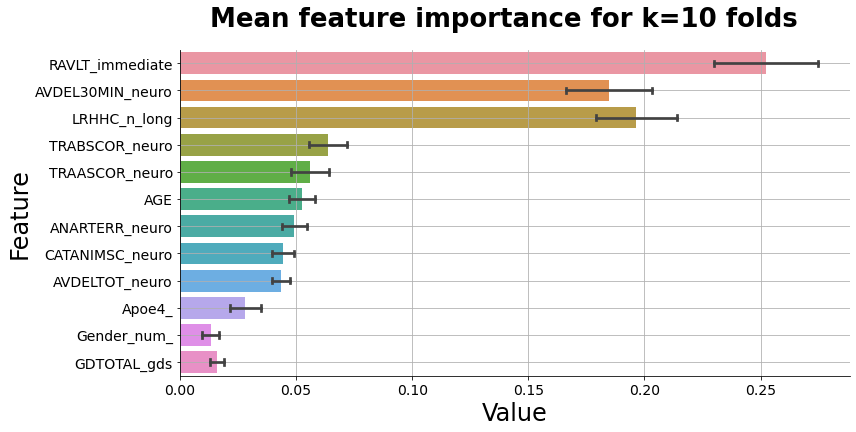

Mean featue importacne plot saved to:
		/home/ingrid/123/results/20211111/3.12_RF-CV10-feat-importance-v.png



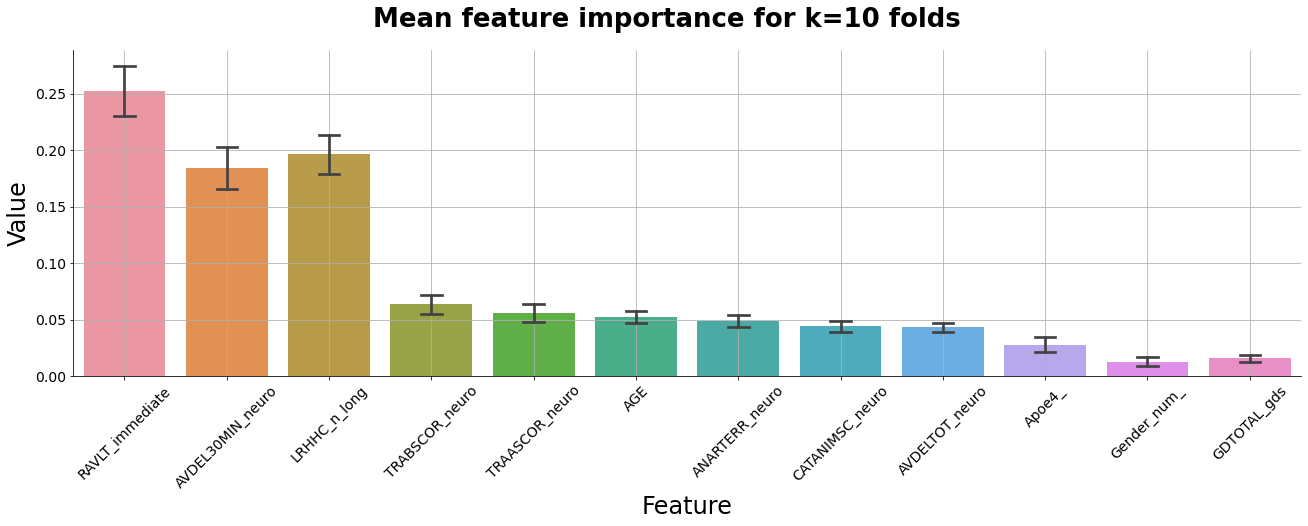

In [129]:
mrfbl.plot_mean_feature_importnce_cv(feat_import_CV, file_name_prefix=FILE_NAME_PREFIX,
                                     orientation='h',folds=FOLDS,figsize=(12,6), results_dir=RESULTS_DIR, save=True)

mrfbl.plot_mean_feature_importnce_cv(feat_import_CV, file_name_prefix=FILE_NAME_PREFIX,
                                     orientation='v', folds=FOLDS, figsize=(22,6), results_dir=RESULTS_DIR, save=True)

---

## CONFUSION MATRIX

#### NUMBER OF SUBJECTS IN EACH FOLD

In [130]:
if VERBOSE:
    print(f'Subjects in each fold:\n\t{valid_set_len_CV}\n')
    print(f'Meand fold length: {valid_set_len_CV.mean()}')

Subjects in each fold:
	[54. 54. 54. 54. 54. 54. 54. 54. 54. 53.]

Meand fold length: 53.9


#### PLOT CONFUSION MATRIX

Confusion matrix saved to:

		/home/ingrid/123/results/20211111/3.12_RF-conf-matrix-CV10.png



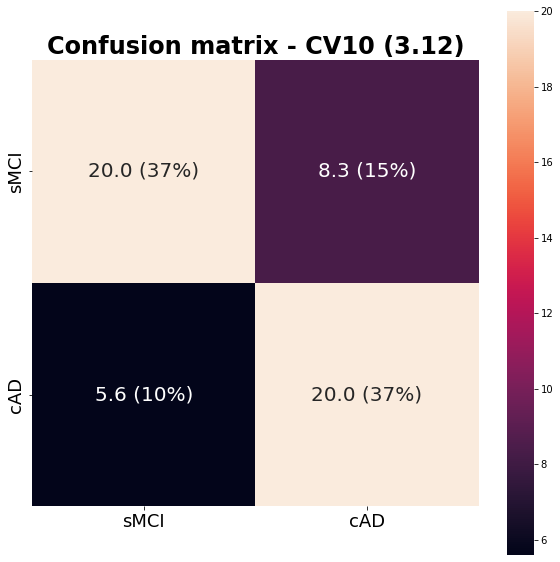

In [131]:
# mean of confusion matix over k=10 folds
conf_mat_mean = conf_matrix_CV.mean(axis=0)
# percantage values of confusion matix according to validatin set lenght
conf_mat_mean_prc = conf_mat_mean / valid_set_len_CV.mean() * 100

mrfbl.plot_confusion_matrix_CV(conf_mat_mean, conf_mat_mean_prc, folds=FOLDS, file_name_number=FILE_NAME_NUMBER,
                                file_name_prefix=FILE_NAME_PREFIX, result_dir=RESULTS_DIR, save=True)

---

## CORELATION (OPTIONAL)

In [132]:
# cor = X_train.corr().abs()
# cor2 = np.tril(cor2,  k=0)

# cor2 = pd.DataFrame(np.where(cor2>0.4, cor, 0), columns=X_train.columns)
# cor2.set_index(X_train.columns, inplace=True)

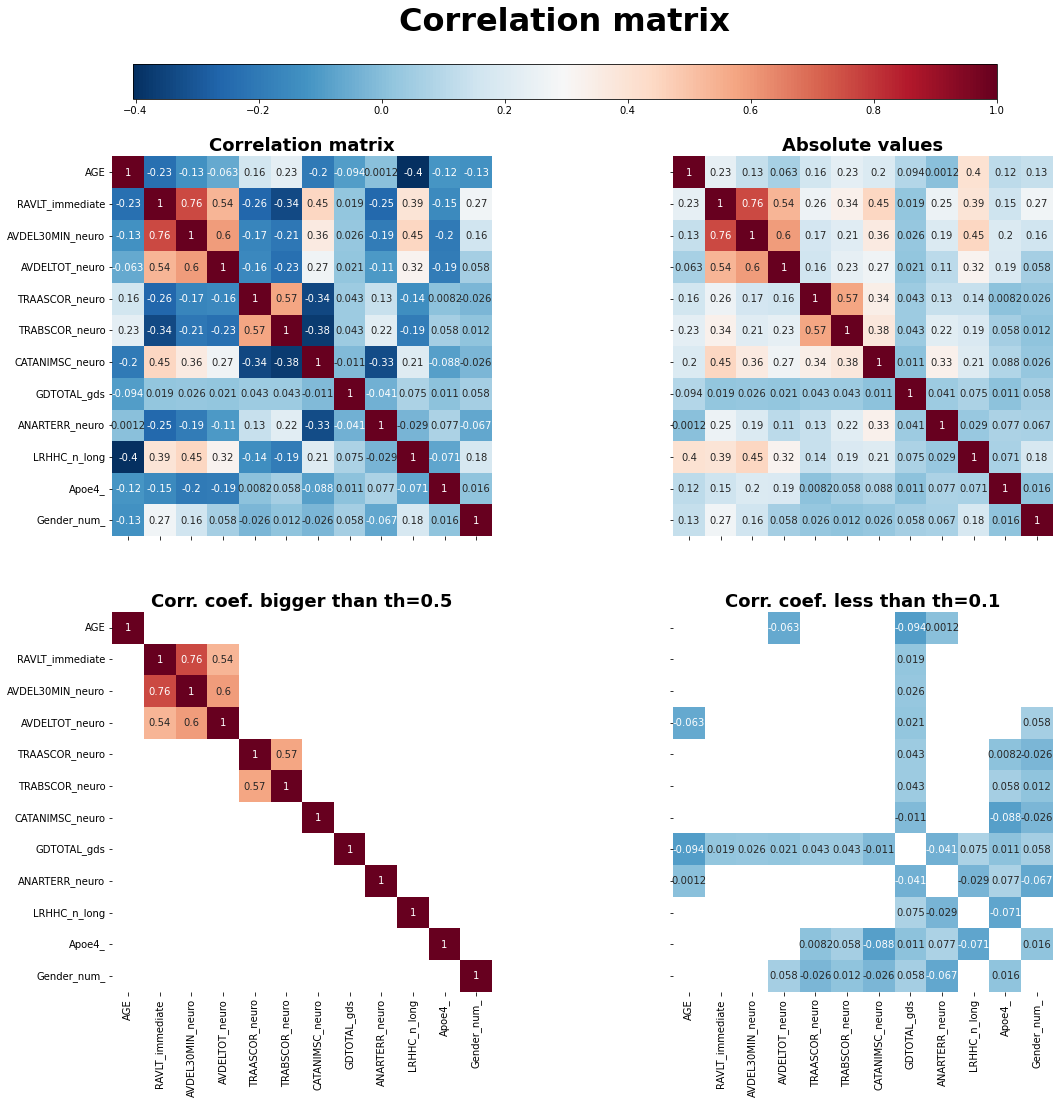

In [133]:
if VERBOSE:
    cor = X_train.corr()
    mn, mx = cor.values.min(), cor.values.max()
    cor_abs = X_train.corr().abs()    
    th1, th2 = 0.5, 0.1
    cor_th1 = cor[cor_abs>th1]
    cor_th2 = cor[cor_abs<th2]
    
    
    
    f,ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=(20,16))
    sns.heatmap(cor, annot=True, cmap='RdBu_r', ax=ax[0,0], vmin=mn, vmax=mx, cbar=False)
    sns.heatmap(cor_abs, annot=True, cmap='RdBu_r', ax=ax[0,1], vmin=mn, vmax=mx, cbar=False)
    sns.heatmap(cor_th1, annot=True, cmap='RdBu_r', ax=ax[1,0], vmin=mn, vmax=mx, cbar=False)    
    sns.heatmap(cor_th2, annot=True, cmap='RdBu_r', ax=ax[1,1], vmin=mn, vmax=mx, cbar=False) 
    
    titles = ['Correlation matrix', 'Absolute values', f'Corr. coef. bigger than th={th1}', f'Corr. coef. less than th={th2}']
    for i,a in enumerate(ax.flat[:]):        
        a.set_aspect(aspect=1)
        a.set_title(titles[i], fontsize=18, fontweight='bold')
    
    
    cax = f.add_axes([0.2, 0.90, 0.6, 0.03])
    norm = plt.Normalize(mn, mx)
    sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)
    sm.set_array([])
    f.colorbar(sm, cax=cax, orientation='horizontal')

    plt.suptitle('Correlation matrix', fontsize=32, fontweight='bold')
    plt.subplots_adjust(wspace=0.01, top=0.85)
    #plt.tight_layout(rect=[0,0,1,0.85])

---

## VISUALIZATION (OPTIONAL)

In [134]:
if VERBOSE:
    #https://towardsdatascience.com/how-to-visualize-a-decision-tree-from-a-random-forest-in-python-using-scikit-learn-38ad2d75f21c
    # Extract single tree
    estimator = clf.estimators_[4]

    from sklearn.tree import export_graphviz
    # Export as dot file
    export_graphviz(estimator, out_file='tree.dot', 
                    feature_names = X_train.columns,
                    class_names = ['sMCi','cAD'],
                    rounded = True, proportion = False, 
                    precision = 2, filled = True)

    # Convert to png using system command (requires Graphviz)
    from subprocess import call
    filename1 = FILE_NAME_PREFIX + '-tree.png'
    filename2 = FILE_NAME_PREFIX + '-tree.pdf'

    filepath1 = RESULTS_DIR/filename1
    filepath2 = RESULTS_DIR/filename2

    call(['dot', '-Tpng', 'tree.dot', '-o', filepath1, '-Gdpi=300'])
    call(['dot', '-Tpdf', 'tree.dot', '-o', filepath2, '-Gdpi=600'])

    # Display in jupyter notebook
    display(Image(filename=filepath1))

FileNotFoundError: [Errno 2] No such file or directory: 'dot'

#### REMOVE TEMPORARY `tree.png` and `tree.dot` FILES FROM THE CURRENT FOLDER

In [135]:
if 1:
    [f.unlink() for f in list(Path('.').glob("tree.*"))]

---

# TEST SET

---

#### TEST SETS VISUAL INSPECTIONS (OPTIONAL)

In [136]:
if VERBOSE:    
    tmp_df = pd.DataFrame.from_dict({'X_test_mean':X_test.mean().round(2), 'X_test_std':X_test.std().round(2)})
    
    print('"Original" Test set ')
    display(X_test.head())
    print('\nMean and std comparison')
    display(tmp_df)

"Original" Test set 


AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  TRAASCOR_neuro  \
6    80.4             30.0               1.0             7.0            49.0   
82   77.3             29.0               0.0            11.0           122.0   
184  77.5             35.0               1.0            10.0            27.0   
359  71.1             24.0               0.0             2.0            50.0   
384  83.6             30.0               2.0             9.0            22.0   

     TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  ANARTERR_neuro  \
6             168.0             13.0          0.0            17.0   
82            151.0             17.0          2.0             3.0   
184            69.0             24.0          2.0            22.0   
359            85.0             13.0          2.0             7.0   
384            76.0             18.0          0.0             9.0   

     LRHHC_n_long  Apoe4_  Gender_num_  
6        0.003638     0.0            1  
82       0.003343     1.0            0  
184      0.003149     1.0            1  
359      0.003729     0.0            1  
384      0.003700     0.0            1


Mean and std comparison


X_test_mean  X_test_std
AGE                     73.34        7.51
RAVLT_immediate         34.01        8.73
AVDEL30MIN_neuro         3.58        3.41
AVDELTOT_neuro          10.65        3.43
TRAASCOR_neuro          40.98       20.45
TRABSCOR_neuro         116.34       65.94
CATANIMSC_neuro         17.10        4.77
GDTOTAL_gds              1.64        1.26
ANARTERR_neuro          12.53        9.62
LRHHC_n_long             0.00        0.00
Apoe4_                   0.53        0.50
Gender_num_              0.41        0.49

---

## TRAIN THE RF CLASSIFIER AND PREDICT SUBGROPUS WITH THE USE OF UNSEEN TEST SET

In [137]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

y_test_pred = clf.predict(X_test)

#compare two ways of accuracy calucation
if VERBOSE:
    print(metrics.accuracy_score(y_test, y_test_pred).round(3))
    print(clf.score(X_test, y_test).round(3))

0.662
0.662


## TEST SET SCORES (F1, ACCURACY, RECALL, PRECISION)

In [138]:
# metrics
f1 = metrics.f1_score(y_test, y_test_pred)
acc = metrics.accuracy_score(y_test, y_test_pred)
recall = metrics.recall_score(y_test, y_test_pred)
prec = metrics.precision_score(y_test, y_test_pred)

print(f'F1: {f1:.3f}')
print(f'ACC: {acc:.3f}')
print(f'RECALL: {recall:.3f}')
print(f'PREC: {prec:.3f}')

F1: 0.641
ACC: 0.662
RECALL: 0.646
PREC: 0.636


## CONUSIOM MATRIX

#### PREDICTIONS

In [139]:
bl_test_pred = mrfbl.confusion_matrix_coefficients_TPTNFPFN(X_test, y_test, y_test_pred)

cols2= []
filename = FILE_NAME_PREFIX + f'-TEST-predictions.csv'
bl_test_pred_full = mrfbl.link_prediction_results_with_other_subject_features(bl_loaded, bl_test_pred, cols2, filename,
                                                                              save=True, results_dir=RESULTS_DIR)


Subjects in the predictions table: 139

Predictions have been saved to a file:
		/home/ingrid/123/results/20211111/3.12_RF-TEST-predictions.csv


In [140]:
conf_matrix_test  = metrics.confusion_matrix(y_test, y_test_pred)    

# mean of test confusion matix
conf_mat_mean = conf_matrix_test.mean(axis=0)
# percantage values of confusion matix according to validatin set lenght
conf_matrix_test_prc = conf_matrix_test / y_test.shape[0] * 100


mrfbl.plot_confusion_matrix_TEST(conf_matrix_test, conf_matrix_test_prc, file_name_number=FILE_NAME_NUMBER, file_name_prefix=FILE_NAME_PREFIX,
                                 save=True, results_dir=RESULTS_DIR)

## FEATURE IMPORTANCE

In [141]:
feature_imp = pd.Series(clf.feature_importances_,index=X_train.columns).sort_values(ascending=False)
print(f'Feature importance for the train set:\n\n{feature_imp.to_string()}')

Feature importance for the train set:

RAVLT_immediate     0.267645
LRHHC_n_long        0.190457
AVDEL30MIN_neuro    0.187325
TRABSCOR_neuro      0.063144
CATANIMSC_neuro     0.053897
AVDELTOT_neuro      0.049532
AGE                 0.048035
TRAASCOR_neuro      0.043137
ANARTERR_neuro      0.042345
Apoe4_              0.027801
GDTOTAL_gds         0.016273
Gender_num_         0.010410


Mean featue importacne plot saved to:
		/home/ingrid/123/results/20211111/3.12_RF-TEST-feat-importance-h.png



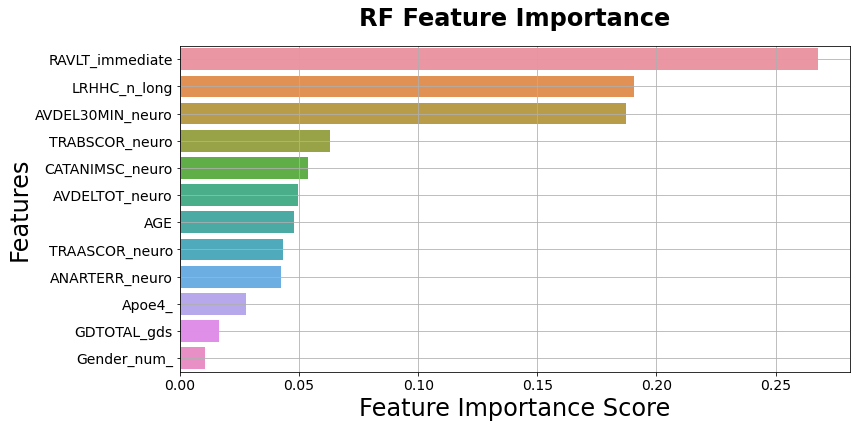

Mean featue importacne plot saved to:
		/home/ingrid/123/results/20211111/3.12_RF-TEST-feat-importance-v.png



In [142]:
mrfbl.plot_single_feature_importnce(feature_imp,
                                    FILE_NAME_PREFIX, orientation='h', figsize=(12,6), results_dir = RESULTS_DIR)

mrfbl.plot_single_feature_importnce(feature_imp,
                                    FILE_NAME_PREFIX, orientation='v', figsize=(22,6), results_dir = RESULTS_DIR)

# Slice datafilen 

In [143]:
# This is to save the four dataframes with the excact subjects used in this model
X_test.to_csv(RESULTS_DIR / '3.12_X_test.csv')
X_train.to_csv(RESULTS_DIR / '3.12_X_train.csv')
y_test.to_csv(RESULTS_DIR / '3.12_y_test.csv')
y_train.to_csv(RESULTS_DIR / '3.12_y_train.csv')

Xy_train = pd.concat([X_train, y_train], axis=1).reindex(X_train.index)
Xy_train.to_csv(RESULTS_DIR / '3.12_Xy_train.csv')

Xy_test = pd.concat([X_test, y_test], axis=1).reindex(X_test.index)
Xy_test.to_csv(RESULTS_DIR / '3.12_Xy_test.csv')

# For hele datafilen brukt i analyse (altsaa samme som BL, but without subjects who had missing values)
Xy_train_test = frames = [Xy_train, Xy_test] 
Xy_train_test = pd.concat(frames)

Xy_train_test.to_csv(RESULTS_DIR / '3.12_Xy_test_train.csv')

# Slice datafilen 2 
This is to concatinate the two prediction tables created above to get a dataframe containing:
1. all features from main script with only  
2. extra column containing information about prediction (i.e. TN,FP, FN, TP) 

In [144]:
# Load prediction-files for CV 
prediction_train = pd.read_csv ('../results/20211111/3.12_RF-CV10-predictions.csv')
prediction_train.shape

(539, 140)

In [145]:
# Load prediction-files for TEST 
prediction_test = pd.read_csv ('../results/20211111/3.12_RF-TEST-predictions.csv')
prediction_test.shape

(139, 138)

In [147]:
# Concatinate these the two prediction tables created above to create a dataframe containing:
# 1. all features from main script with only  
# 2. extra column containing information about prediction (i.e. TN,FP, FN, TP) 

prediction_full = pd.concat([prediction_train, prediction_test])
prediction_full.shape
prediction_full.to_csv(RESULTS_DIR / '3.12_FULL-prediction.csv')

---

# FEATURE PERMUTATION WITH `eli5` 
([www](https://eli5.readthedocs.io/en/latest/overview.html))

In [55]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=4, max_features=4,
                       min_samples_leaf=2, n_estimators=75, random_state=42)

#### TRAIN SET

In [55]:
# perm = PermutationImportance(clf, random_state=RANDOM_STATE).fit(X_train, y_train)
# eli5.show_weights(perm, feature_names = X_train.columns.tolist())

## TEST SET

In [56]:
perm = PermutationImportance(clf, random_state=RANDOM_STATE).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist(),)

---

# PARTIAL DEPENDENCE PLOTS

#### 1D PDPs

In [65]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=4, max_features=4,
                       min_samples_leaf=2, n_estimators=75, random_state=42)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


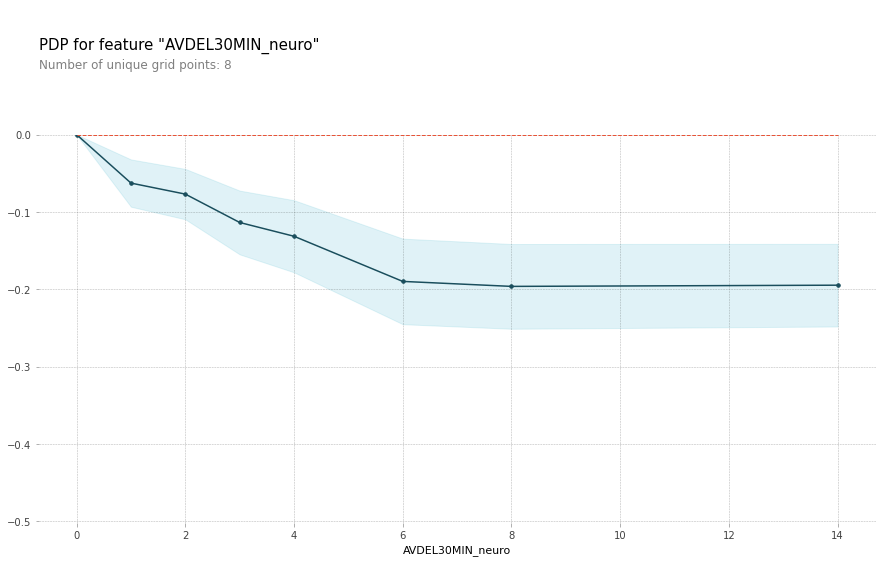

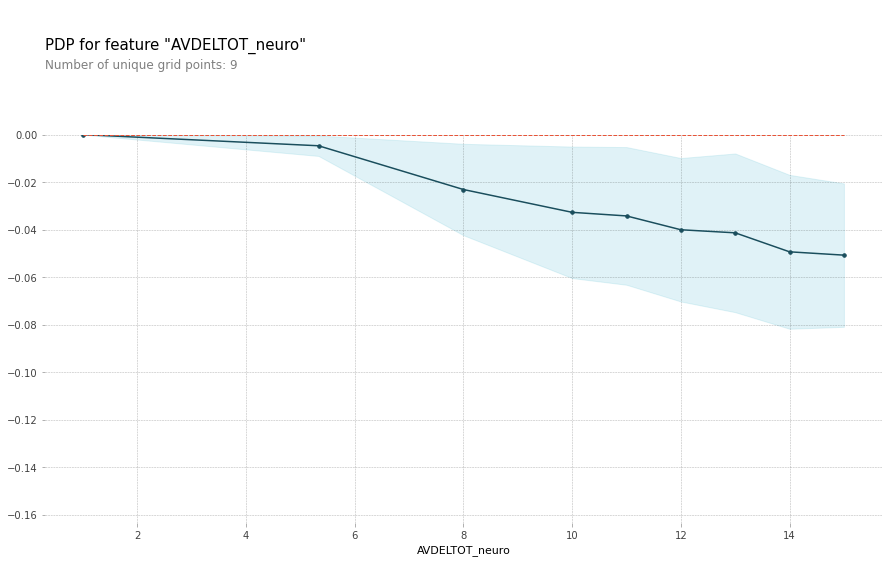

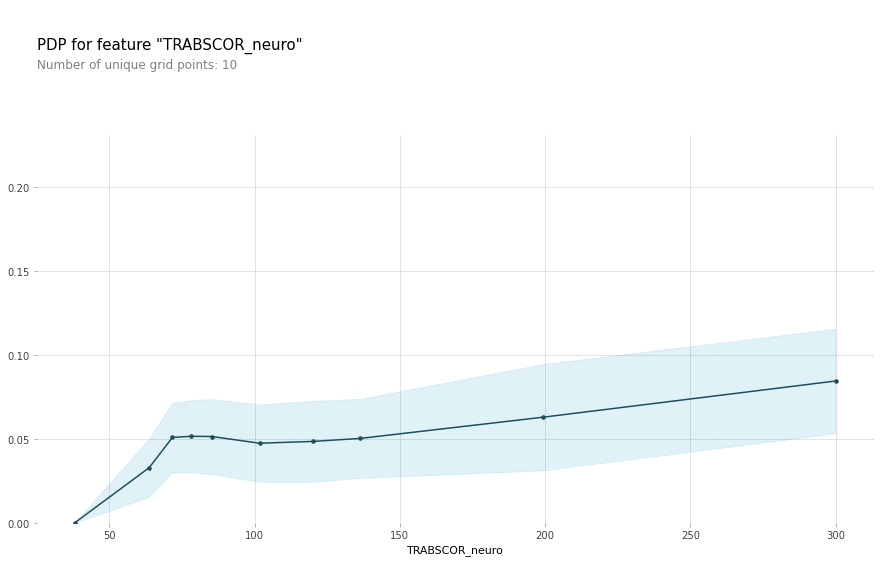

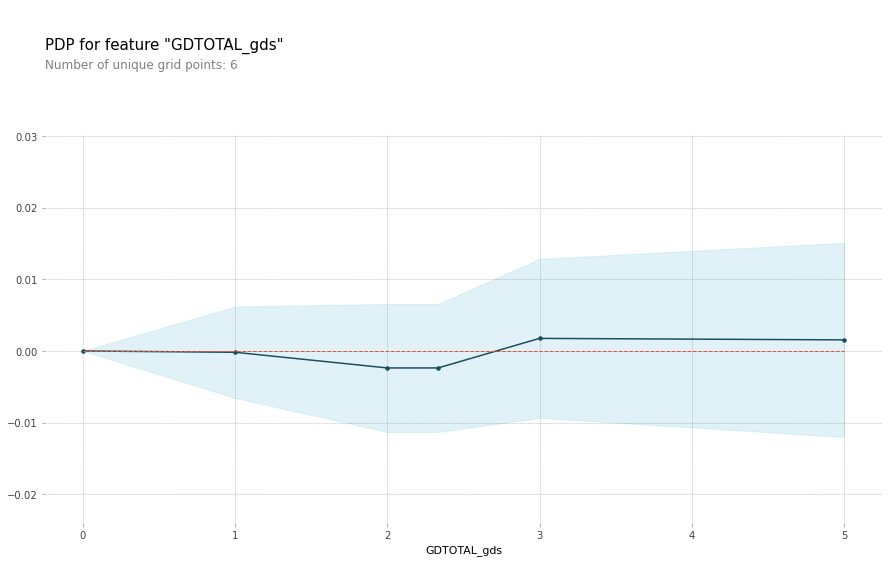

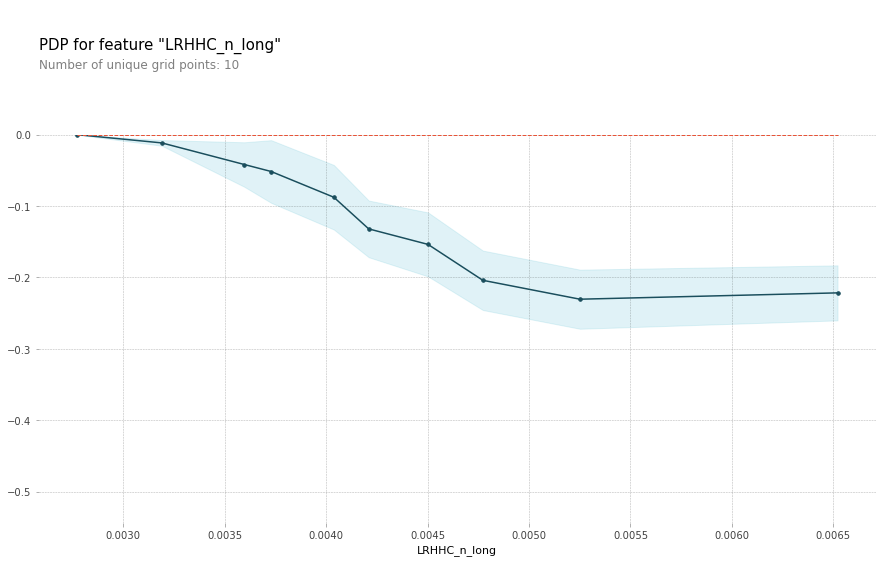

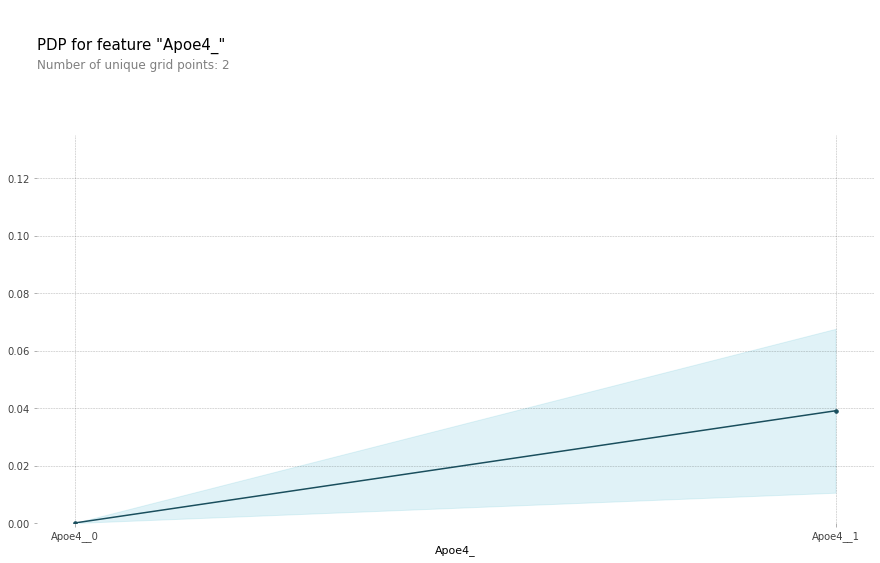

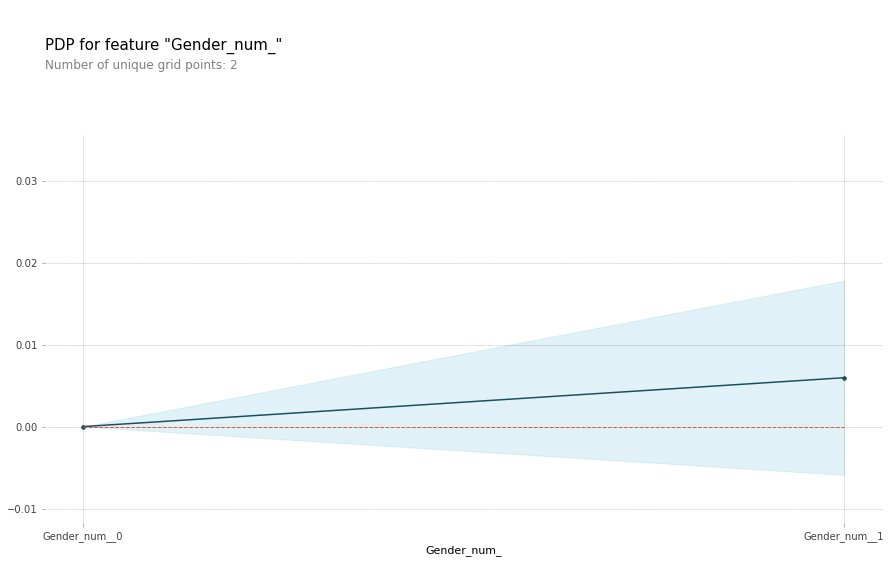

In [66]:
for feature in X_test.columns:
    pdp_goals = pdp.pdp_isolate(model=clf, dataset=X_test, model_features=X_test.columns.tolist(),
                                feature=feature)    
    pdp.pdp_plot(pdp_goals, feature)

    file_name_prefix_ext = f'{FILE_NAME_PREFIX}-pdp-TEST-{feature}.png'
    file_name_prefix_path = RESULTS_DIR / file_name_prefix_ext
    plt.savefig(file_name_prefix_path)

    plt.show()

#### 2D PDPs

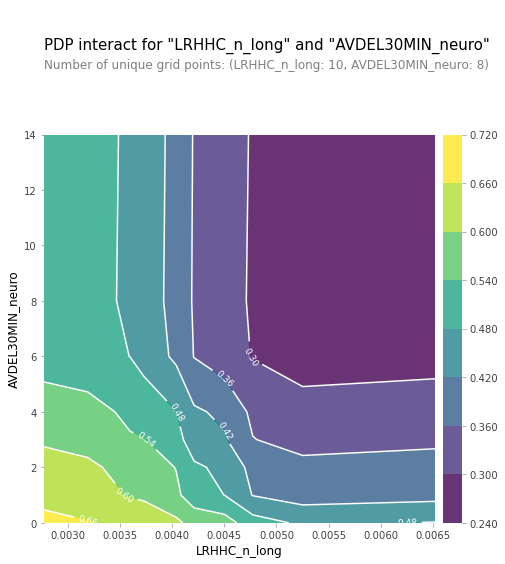

In [67]:
feat = ['LRHHC_n_long', 'AVDEL30MIN_neuro']
interact  =  pdp.pdp_interact(model=clf, dataset=X_test, model_features=X_test.columns.tolist(), features=feat)
pdp.pdp_interact_plot(pdp_interact_out=interact, feature_names=feat, plot_type='contour')
plt.show()

In [ ]:
feat = ['LRHHC_n_long', 'AVDEL30MIN_neuro']
interact  =  pdp.pdp_interact(model=clf, dataset=X_test, model_features=X_test.columns.tolist(), features=feat)
pdp.pdp_interact_plot(pdp_interact_out=interact, feature_names=feat, plot_type='grid')
plt.show()

---

---

# PDP AND ICE PLOTS WITH SCIKIT-LEARN ([www](https://scikit-learn.org/stable/modules/partial_dependence.html))

In [145]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=4, max_features=4,
                       min_samples_leaf=2, n_estimators=75, random_state=42)

In [146]:
print(FEATURES)

['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_', 'Subgroup_', 'Subgroup_num_', 'Usage_', 'Gender_num_', 'PTGENDER']


#### PARTIAL DEPENDENCE PLOTS

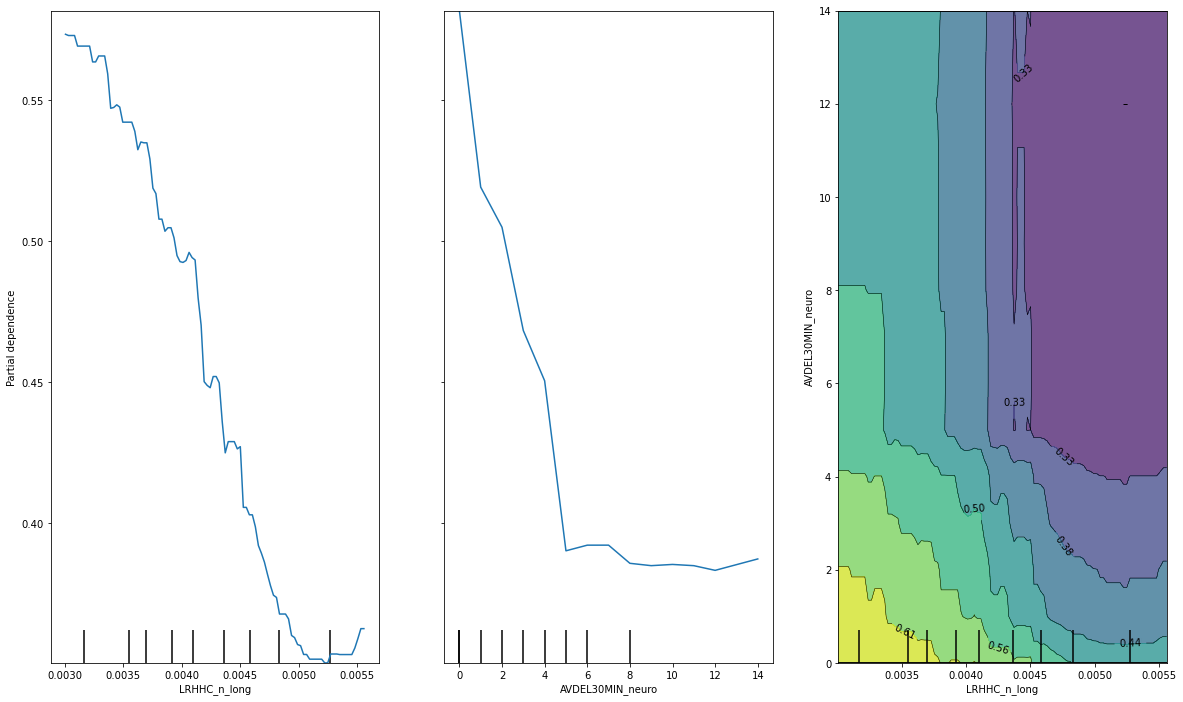

In [147]:
fig, ax = plt.subplots(figsize=(20,12))
plot_partial_dependence(clf, X_test, ['LRHHC_n_long','AVDEL30MIN_neuro', ('LRHHC_n_long', 'AVDEL30MIN_neuro')], ax=ax, n_jobs=32)

In [ ]:
fig, ax = plt.subplots(figsize=(20,12))
plot_partial_dependence(clf, X_test, ['LRHHC_n_long','RAVLT_immediate', ('LRHHC_n_long', 'RAVLT_immediate')], ax=ax, n_jobs=32)

In [ ]:
fig, ax = plt.subplots(figsize=(20,12))
plot_partial_dependence(clf, X_test, ['AVDEL30MIN_neuro','RAVLT_immediate', ('AVDEL30MIN_neuro', 'RAVLT_immediate')], ax=ax, n_jobs=32)

#### INDIVIDUAL CONDITIONAL EXPECTATION (ICE) PLOTS - TRAIN SET

In [149]:
clf = RandomForestClassifier(random_state=RANDOM_STATE, **BEST_PARAMS)
clf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=4, max_features=4,
                       min_samples_leaf=2, n_estimators=75, random_state=42)

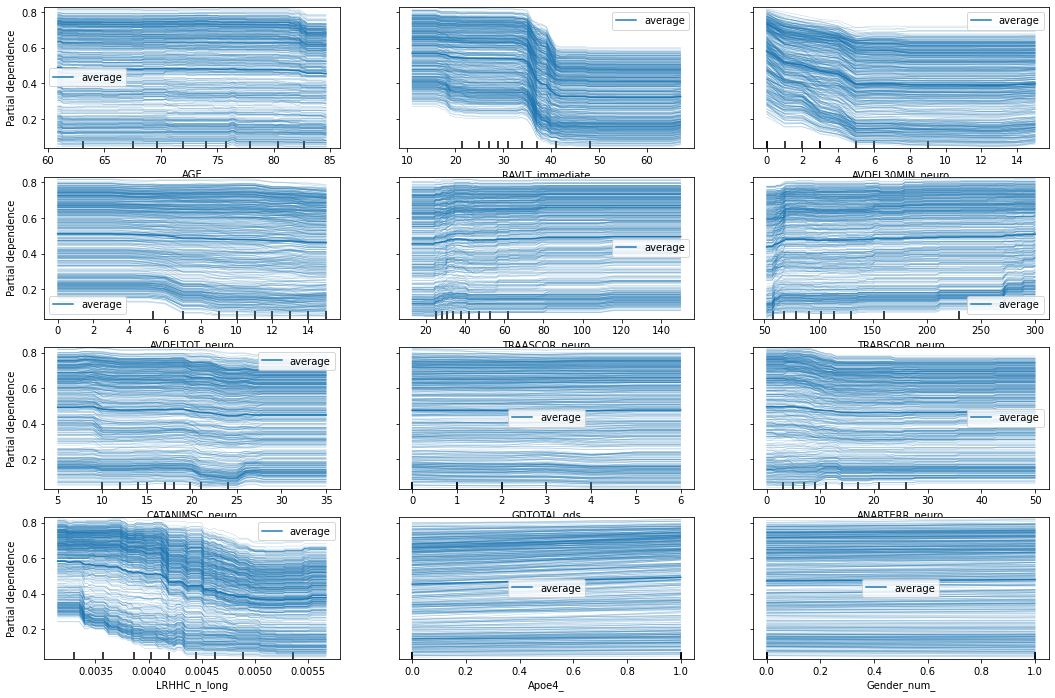

In [150]:
fig,ax = plt.subplots(figsize=(18,12),)
_=plot_partial_dependence(clf, X_train, features=X_train.columns, kind='both', ax=ax)

#### INDIVIDUAL CONDITIONAL EXPECTATION (ICE) PLOTS - TEST SET

In [148]:
fig,ax = plt.subplots(figsize=(18,12))
_=plot_partial_dependence(clf, X_test, features=X_test.columns, kind='both', ax=ax)


---

Code copied from https://scikit-learn.org/stable/auto_examples/inspection/plot_partial_dependence.html#sphx-glr-auto-examples-inspection-plot-partial-dependence-py

Changed features and titles obviously, but also 'est' to 'clf'

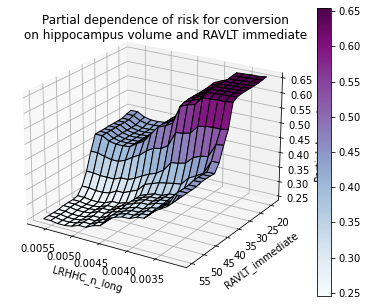

In [168]:
from time import time
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.neural_network import MLPRegressor

import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence
from sklearn.inspection import PartialDependenceDisplay

import numpy as np
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

features = ("LRHHC_n_long", "RAVLT_immediate")
pdp = partial_dependence(
    clf, X_train, features=features, kind="average", grid_resolution=20
)
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
fig.add_axes(ax)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel("Partial dependence")
# pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle(
    "Partial dependence of risk for conversion\n"
    "on hippocampus volume and RAVLT immediate"
)
plt.subplots_adjust(top=0.9)
plt.show()

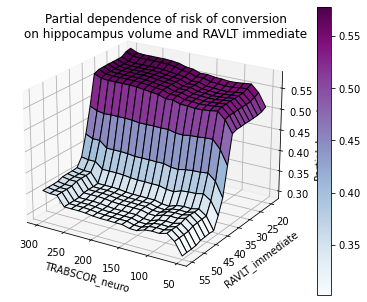

In [167]:
fig = plt.figure()

features = ("TRABSCOR_neuro", "RAVLT_immediate")
pdp = partial_dependence(
    clf, X_train, features=features, kind="average", grid_resolution=20
)
XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
Z = pdp.average[0].T
ax = Axes3D(fig)
fig.add_axes(ax)
surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel("Partial dependence")
# pretty init view
ax.view_init(elev=22, azim=122)
plt.colorbar(surf)
plt.suptitle(
    "Partial dependence of risk of conversion\n"
    "on hippocampus volume and RAVLT immediate"
)
plt.subplots_adjust(top=0.9)
plt.show()

In [70]:
# FEATURE PERMUTATION WITH GROUPS

In [71]:
import mci_info as minfo
import mci_utils as mutils
import mci_freesurfer as mfs
import mci_rf_bl as mrfbl
import mci_permutation as mperm

Repetition(s) = 201
Averaging mode!
random_state = None

All features:
	['AGE', 'RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro', 'TRAASCOR_neuro', 'TRABSCOR_neuro', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'ANARTERR_neuro', 'LRHHC_n_long', 'Apoe4_', 'Gender_num_']

Feature groups:
	['RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro']
	['TRAASCOR_neuro', 'TRABSCOR_neuro']

Single features:
	['AGE', 'ANARTERR_neuro', 'Apoe4_', 'CATANIMSC_neuro', 'GDTOTAL_gds', 'Gender_num_', 'LRHHC_n_long']





f1    acc  recall   prec
Group_0          0.109  0.105   0.106  0.110
LRHHC_n_long     0.014  0.012   0.015  0.012
Apoe4_           0.014  0.010   0.019  0.009
CATANIMSC_neuro  0.010  0.004   0.019  0.000
Group_1          0.004 -0.005   0.020 -0.013
GDTOTAL_gds     -0.004 -0.003  -0.006 -0.002
Gender_num_     -0.004 -0.005  -0.002 -0.007
ANARTERR_neuro  -0.011 -0.009  -0.014 -0.008
AGE             -0.014 -0.013  -0.014 -0.013

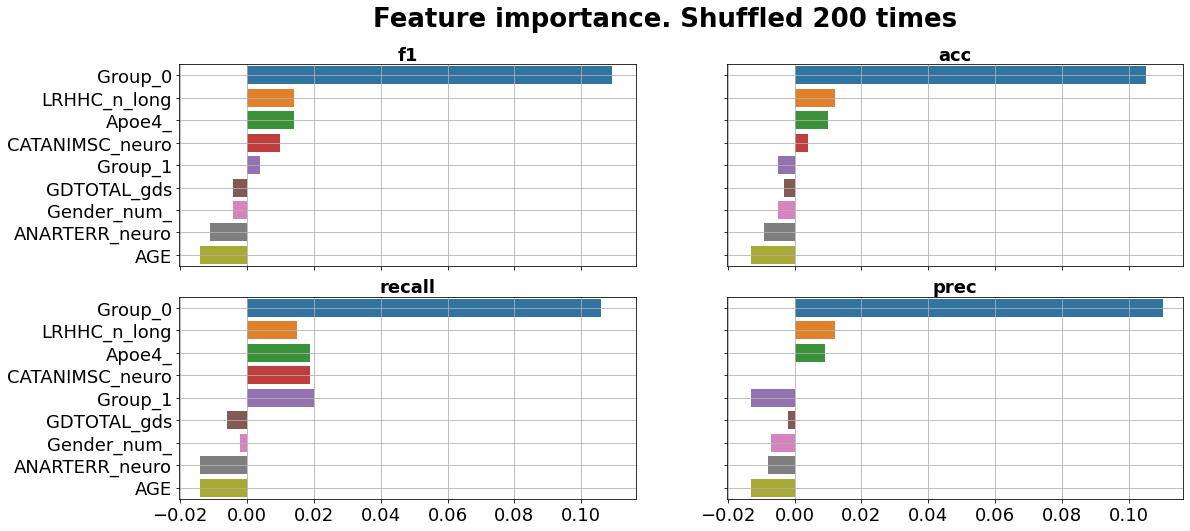

Group_0:['RAVLT_immediate', 'AVDEL30MIN_neuro', 'AVDELTOT_neuro']
Group_1:['TRAASCOR_neuro', 'TRABSCOR_neuro']


In [73]:
df, features = mperm.shuffle_features_with_groups(clf, X_test, y_test,
                                                  precission=3,
                                                  verbose=True,
                                                  random_state=RANDOM_STATE,
                                                  repetitions=200,
                                                  sortBy='f1',
                                                  ascending=False,
                                                  groups=[['RAVLT_immediate','AVDEL30MIN_neuro', 'AVDELTOT_neuro'],
                                                          ['TRAASCOR_neuro','TRABSCOR_neuro']])
display(df)
mperm.plot_permuted_features(df,
                             file_name_prefix=FILE_NAME_PREFIX,
                             type='shuffle',
                             title_suffix='Shuffled 200 times',
                             save=False,
                             results_dir=RESULTS_DIR,
                             figsize=(18,8)                             
                            )
mperm._print_group_names(features)

## Playing with SHAP 

In [74]:
#importing shap package
import shap
shap.initjs()

In [75]:
# Printing shape of data 
print("Training features shape:", X_train.shape)
print("Training target shape:", X_test.shape)
print()
print("Test features shape:",y_train.shape)
print("Test target shape",y_test.shape)

Training features shape: (539, 12)
Training target shape: (139, 12)

Test features shape: (539,)
Test target shape (139,)


In [76]:
explainer = shap.Explainer(clf)
shap_test = explainer(X_test)
print(f"Shap values length: {len(shap_test)}\n")
print("*****************************************")
print(f"Sample shap values:\n{shap_test[0]}")

Shap values length: 139

*****************************************
Sample shap values:
.values =
array([[-0.0054545 ,  0.0054545 ],
       [-0.07023008,  0.07023008],
       [-0.03494897,  0.03494897],
       [-0.01428373,  0.01428373],
       [-0.00657197,  0.00657197],
       [-0.01344778,  0.01344778],
       [-0.003838  ,  0.003838  ],
       [-0.00096569,  0.00096569],
       [ 0.01572787, -0.01572787],
       [-0.09424714,  0.09424714],
       [ 0.02360356, -0.02360356],
       [-0.00518553,  0.00518553]])

.base_values =
array([0.52425479, 0.47574521])

.data =
array([8.04000000e+01, 3.00000000e+01, 1.00000000e+00, 7.00000000e+00,
       4.90000000e+01, 1.68000000e+02, 1.30000000e+01, 0.00000000e+00,
       1.70000000e+01, 3.63758764e-03, 0.00000000e+00, 1.00000000e+00])


Explanations regarding the cell abode:
- The length of shap_test is 139 because it contains a record for each test instance (i.e. patient in TEST set) 
- Built into shap_test there are three metrics (NB! Displayed here for subject with index==0 is displayed)
    - **shap_test[0].base_values is Base values for target**: this is also known as the expected value (explainer.expected_value), tells us the probability of for each class (for regression problems), whereas in classification models this tells us the probability for each class. We will focus on the positive class (i.e. y == 1, convertion to AD. Not to self: finne ut hva det betyre å "focuse on the positive class". 
    - **shap_test[0.data**: value for each feature]
    - **shap_test[0].values**: Shap values for each features

In [77]:
print(f"Expected value: {explainer.expected_value[1]:.2f}")
print(f"Average target value (training data): {y_train.mean():.2f}")
print(f"Base value: {np.unique(shap_test.base_values)[0]:.2}")

Expected value: 0.48
Average target value (training data): 0.47
Base value: 0.48


In [78]:
(shap_test.data == X_test).describe()

AGE RAVLT_immediate AVDEL30MIN_neuro AVDELTOT_neuro TRAASCOR_neuro  \
count    139             139              139            139            139   
unique     1               1                1              1              1   
top     True            True             True           True           True   
freq     139             139              139            139            139   

       TRABSCOR_neuro CATANIMSC_neuro GDTOTAL_gds ANARTERR_neuro LRHHC_n_long  \
count             139             139         139            139          139   
unique              1               1           1              1            1   
top              True            True        True           True         True   
freq              139             139         139            139          139   

       Apoe4_ Gender_num_  
count     139         139  
unique      1           1  
top      True        True  
freq      139         139

In [79]:
# Converting to data frame
pd.DataFrame(shap_test.data, columns=shap_test.feature_names, 
             index=X_test.index)

AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  TRAASCOR_neuro  \
6     80.4             30.0               1.0             7.0            49.0   
82    77.3             29.0               0.0            11.0           122.0   
184   77.5             35.0               1.0            10.0            27.0   
359   71.1             24.0               0.0             2.0            50.0   
384   83.6             30.0               2.0             9.0            22.0   
...    ...              ...               ...             ...             ...   
6238  61.7             65.0              14.0            15.0            29.0   
6244  73.4             44.0               8.0            15.0            43.0   
6261  69.3             49.0               6.0            11.0            24.0   
6267  60.1             51.0              10.0            15.0            28.0   
6309  68.8             29.0               1.0            11.0            28.0   

      TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  ANARTERR_neuro  \
6              168.0             13.0          0.0            17.0   
82             151.0             17.0          2.0             3.0   
184             69.0             24.0          2.0            22.0   
359             85.0             13.0          2.0             7.0   
384             76.0             18.0          0.0             9.0   
...              ...              ...          ...             ...   
6238            60.0             22.0          1.0             4.0   
6244            73.0             18.0          3.0             4.0   
6261            99.0             17.0          1.0            43.0   
6267            57.0             22.0          2.0             6.0   
6309            66.0             13.0          1.0             4.0   

      LRHHC_n_long  Apoe4_  Gender_num_  
6         0.003638     0.0          1.0  
82        0.003343     1.0          0.0  
184       0.003149     1.0          1.0  
359       0.003729     0.0          1.0  
384       0.003700     0.0          1.0  
...            ...     ...          ...  
6238      0.005343     0.0          0.0  
6244      0.003991     0.0          0.0  
6261      0.003548     0.0          0.0  
6267      0.005275     0.0          1.0  
6309      0.004956     1.0          1.0  

[139 rows x 12 columns]

In [80]:
shap_df = pd.DataFrame(shap_test.values[:,:,0],
                       columns=shap_test.feature_names,
                       index=X_test.index)
shap_df

AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  \
6    -0.005454        -0.070230         -0.034949       -0.014284   
82   -0.006304        -0.070079         -0.083202       -0.011625   
184  -0.005671        -0.034849         -0.030934       -0.010018   
359  -0.009901        -0.069213         -0.100274       -0.031499   
384   0.029511        -0.066824         -0.004101       -0.009756   
...        ...              ...               ...             ...   
6238 -0.002913         0.152266          0.081825        0.014854   
6244 -0.004315         0.200981          0.097182        0.018864   
6261 -0.002281         0.203130          0.083268       -0.001607   
6267 -0.014855         0.162895          0.090387        0.019017   
6309 -0.005705        -0.059386         -0.032292       -0.005825   

      TRAASCOR_neuro  TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  \
6          -0.006572       -0.013448        -0.003838    -0.000966   
82         -0.010218       -0.004672         0.000164     0.002771   
184         0.020965        0.009436         0.038734     0.001063   
359        -0.005522       -0.004463        -0.002944     0.001092   
384         0.025981       -0.002809        -0.004868     0.000134   
...              ...             ...              ...          ...   
6238        0.003592        0.016271         0.020089    -0.001230   
6244       -0.000836       -0.003297        -0.008534    -0.001785   
6261        0.009399       -0.004147        -0.002081    -0.000290   
6267        0.006863        0.030286         0.016455     0.000481   
6309        0.017569       -0.001871         0.000328     0.000958   

      ANARTERR_neuro  LRHHC_n_long    Apoe4_  Gender_num_  
6           0.015728     -0.094247  0.023604    -0.005186  
82         -0.022109     -0.084706 -0.015610     0.004237  
184         0.021778     -0.098403 -0.034261    -0.003025  
359        -0.015405     -0.071365  0.022436    -0.007716  
384        -0.002113     -0.086243  0.031490    -0.006344  
...              ...           ...       ...          ...  
6238       -0.005342      0.088316  0.014248     0.000306  
6244       -0.017122     -0.030853  0.013575     0.001977  
6261        0.001343     -0.088694  0.013833     0.000646  
6267       -0.002234      0.078134  0.014099    -0.000313  
6309       -0.027728      0.120996 -0.029388    -0.008276  

[139 rows x 12 columns]

In [81]:
# We can see the shap values by feature for each record. If we add these shap values to the expected value, we will get the prediction:
# Dette skal (i følge notebooken) være |True| ikke |False|, men troooooor kanskje det er relatert til at notboken i dette tilfellet snakket om regression og ikke klassifikasjon. 
np.isclose(clf.predict(X_test), 
           explainer.expected_value[0] + shap_df.sum(axis=1))

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

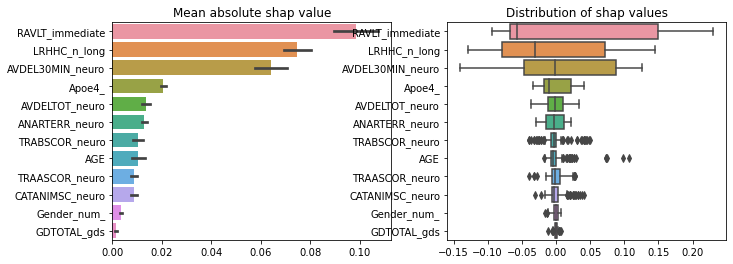

In [82]:
# The left subplot shows the mean absolute shap value for each feature whereas the right subplot shows the distribution of the shap values by feature. 
# One takeaway from these graphs is that RAVLT_immediate has the biggest contribution among the 12 features being used.


columns = shap_df.apply(np.abs).mean()\
                 .sort_values(ascending=False).index
fig, ax = plt.subplots(1, 2, figsize=(11,4))
sns.barplot(data=shap_df[columns].apply(np.abs), orient='h', 
            ax=ax[0])
ax[0].set_title("Mean absolute shap value")
sns.boxplot(data=shap_df[columns], orient='h', ax=ax[1])
ax[1].set_title("Distribution of shap values");

In [83]:
shap.summary_plot(shap_test)

TypeError: only integer scalar arrays can be converted to a scalar index

In [84]:
print(type(X_train))

<class 'pandas.core.frame.DataFrame'>


In [85]:
numpy_array = X_train.to_numpy()

In [86]:
shap.plots.bar(numpy_array)

AssertionError: You must pass an Explanation object, Cohorts object, or dictionary to bar plot!

In [93]:
shap.summary_plot(numpy_array)

In [102]:
X_train.head()

AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  TRAASCOR_neuro  \
13  80.0             36.0               1.0             8.0            47.0   
26  76.8             27.0               5.0            10.0            61.0   
29  70.9             22.0               0.0             0.0            18.0   
37  72.8             29.0               1.0             8.0            40.0   
55  77.6             30.0               2.0            14.0           150.0   

    TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  ANARTERR_neuro  \
13           139.0             16.0          1.0             4.0   
26           300.0             19.0          4.0            23.0   
29           145.0             18.0          2.0            12.0   
37           101.0             17.0          1.0             6.0   
55           300.0             12.0          0.0             9.0   

    LRHHC_n_long  Apoe4_  Gender_num_  
13      0.003458     0.0            1  
26      0.005251     0.0            0  
29      0.003026     1.0            1  
37      0.002767     0.0            0  
55      0.002814     0.0            0

In [100]:
array = X_train.to_records(index=True)

In [103]:
#print(array)

---

### EXPLORING THE CHARACTERISTICS WITH THE FOUR CLASSES (TN, FP, FN, TP) 

In [58]:
# This datafile contains data from participants in test set ('Usage_'==test), as well well how they were classified. 
predictions_bl = pd.read_csv('../results/20211111/3.12_RF-TEST-predictions.csv')
predictions_bl.head()

Unnamed: 0  RID        PTID PTGENDER  PTEDUCAT    EXAMDATE   AGE  Years_bl  \
0           6    6  100_S_0006   Female        13  2005-11-29  80.4       0.0   
1          82   57  018_S_0057     Male        20  2006-01-06  77.3       0.0   
2         184  126  023_S_0126   Female        14  2006-02-16  77.5       0.0   
3         359  204  035_S_0204   Female        16  2006-02-23  71.1       0.0   
4         384  217  023_S_0217   Female        18  2006-02-28  83.6       0.0   

   Month  Month_bl  ... Subgroup_ Subgroup_num_ TOTAL13_adas_Nr_ Usage_  \
0      0       0.0  ...      sMCI             0                6   test   
1      0       0.0  ...       cAD             1                5   test   
2      0       0.0  ...       cAD             1               13   test   
3      0       0.0  ...       cAD             1                7   test   
4      0       0.0  ...       cAD             1                9   test   

   VISCODE3_ Visits_Nr_  y_true_  y_pred_  CM_pred_ MERGE_predictions_  
0         bl          7     sMCI      cAD        FP               both  
1         bl          7      cAD      cAD        TP               both  
2         bl         19      cAD      cAD        TP               both  
3         bl          9      cAD      cAD        TP               both  
4         bl         14      cAD      cAD        TP               both  

[5 rows x 138 columns]

In [64]:
predictions_bl.columns

Index(['Unnamed: 0', 'RID', 'PTID', 'PTGENDER', 'PTEDUCAT', 'EXAMDATE', 'AGE',
       'Years_bl', 'Month', 'Month_bl',
       ...
       'Subgroup_', 'Subgroup_num_', 'TOTAL13_adas_Nr_', 'Usage_', 'VISCODE3_',
       'Visits_Nr_', 'y_true_', 'y_pred_', 'CM_pred_', 'MERGE_predictions_'],
      dtype='object', length=138)

### Stealing (and modifiing) Mareks function for box and violin plots

In [65]:
def plot_violin_box_feature_vs_classification(df, feature_name='AGE', **kw):
    """
    Plots violin and box plot figures of feature vs. Classification 
    
    Changes: Additional parameter: title, by deafault figure title was assumed as feature name.
            There is possibility to set any title.
            
    
    Parameters:
    -------------
    df - data frame, a table to take features from (a pandas dataframe),
    feature_name - name of a feature to plot (a string, default: 'AGE')
    
    Optional:
    ----------
    title - a figure title (a string, dafault: feature_name vs. Subgroup)
    points - weather or not to plot jitter dots (a boolean value, default:True)
    figsize - figure size (a tuple with size, deafault: (16,8))
    
    
    x_label - x axis label (a string, default: 'Subgroup')
    x_label_size - x label font size (an inteager, default: 28)
    x_label_labelpad - x label distance from axis (an inteager, default:20)
    
    y_label - y axis label (a string, default: feature_name)
    y_label_size - y label font size (an inteager, default: 28)
    y_label_labelpad - y label distance from axis (an inteager, default:20)
    
    grid_on - turn on/off a grid (a boolean value, default: True)
    
    subplot_adj - adjust subplot spaces (a list with float numbers).
                Usage:  (left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2,  hspace=0.35)
                Parameters:
                - sub_left
                - sub_bottom
                - sub_right
                - sub_top
                - sub_wspace
                - sub_hspace
                
    
    Created 2020.11.15 / Updated 2021.03.04
    """    
    title = kw.get('title', f'{feature_name} vs. Subgroup')
    points = kw.get('points', True)
    figsize = kw.get('figsize', (16,8))
    
    x_label = kw.get('x_label', 'Subgroup')
    x_label_size = kw.get('x_label_size', 28)
    x_label_labelpad = kw.get('x_label_labelpad', 10)
    
    y_label = kw.get('y_label', feature_name)
    y_label_size = kw.get('y_label_size', 28)
    y_label_labelpad = kw.get('y_label_labelpad', 10)
    
    # (left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2,  hspace=0.35)
    sub_left = kw.get('sub_left', 0.05)
    sub_bottom = kw.get('sub_bottom', 0.05)
    sub_right = kw.get('sub_right', 0.95)
    sub_top = kw.get('sub_top', 0.9)
    sub_wspace = kw.get('sub_wspace', 0.05)
    sub_hspace = kw.get('sub_hspace', 0.05)
    
    figSaveName = kw.get('figSaveName', '')
    
    
    grid_on = kw.get('grid', True)
        
    
    #title = title if title else f'{feature_name} vs. Subgroup'
    violin, ax = plt.subplots(1,2, figsize=figsize, sharex=True, sharey=True)
    
    _ = plt.suptitle(title, fontsize=26, weight='bold')
    
    _ = sns.violinplot(x='CM_pred_', y=feature_name, hue='PTGENDER', data=df, split=True, ax=ax[0])
    if points:
        _ = sns.stripplot(x="CM_pred_", y=feature_name, hue='PTGENDER', data=df, dodge=True, palette='dark',ax=ax[0])
        
    _ = sns.boxplot(x='CM_pred_', y=feature_name, hue='PTGENDER', data=df,  ax=ax[1])
    

    for a in ax:
        a.set_xlabel(x_label, fontsize=x_label_size, weight='bold', labelpad=x_label_labelpad)
        a.set_ylabel(y_label, fontsize=y_label_size, weight='bold', labelpad=y_label_labelpad)
        
        a.tick_params(axis='both', which='major', labelsize=20)
        a.tick_params(axis='both', which='minor', labelsize=20)
        
        handles, labels = a.get_legend_handles_labels()
        a.legend(handles[0:2], labels[0:2],loc=8, prop={'size': 16})        
        a.grid(grid_on)    
        
    ax[1].set(ylabel=None)
    

### Plotting

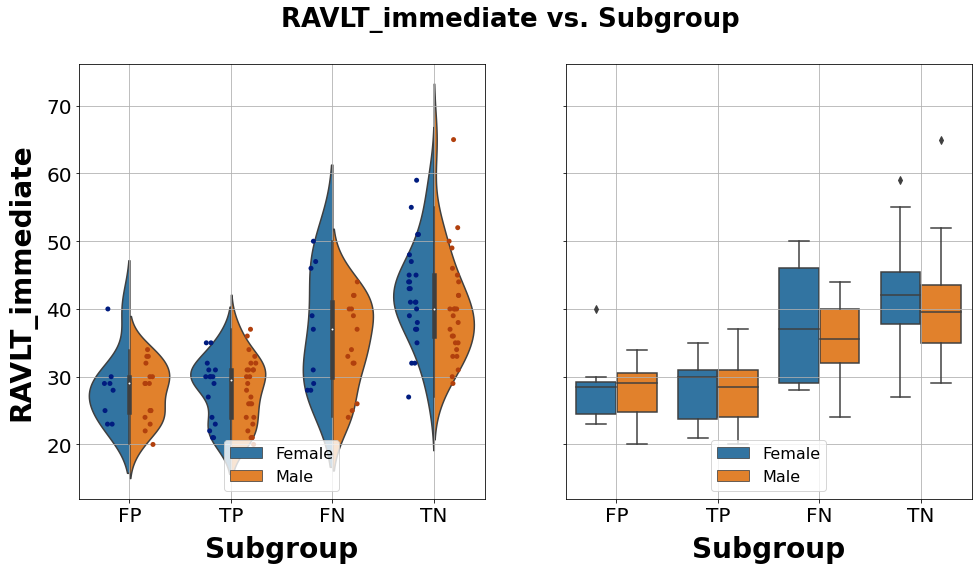

In [71]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='RAVLT_immediate', points=True)

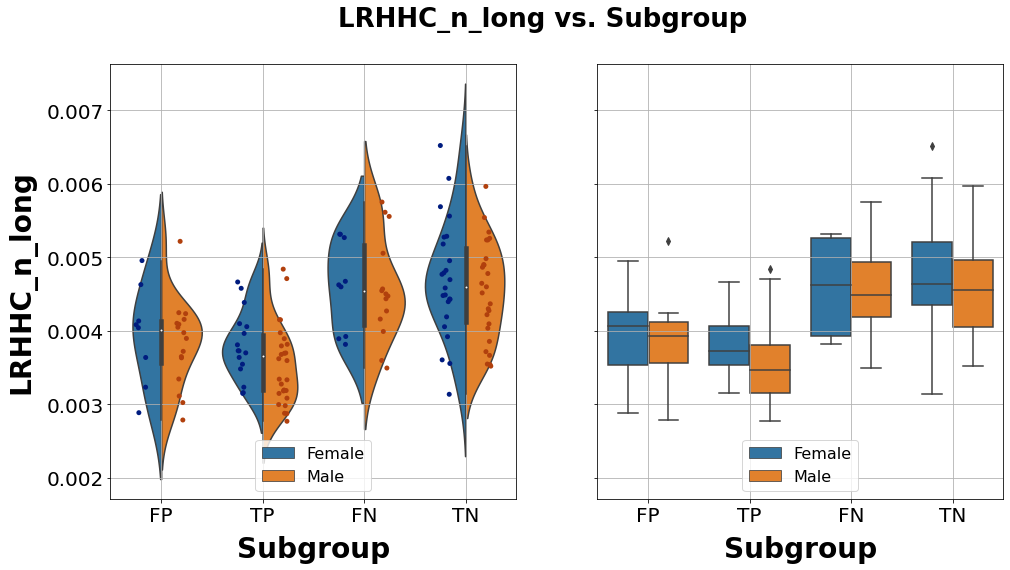

In [70]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='LRHHC_n_long', points=True)

In [72]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='AVDEL30MIN_neuro', points=True)

In [69]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='TRABSCOR_neuro', points=True)

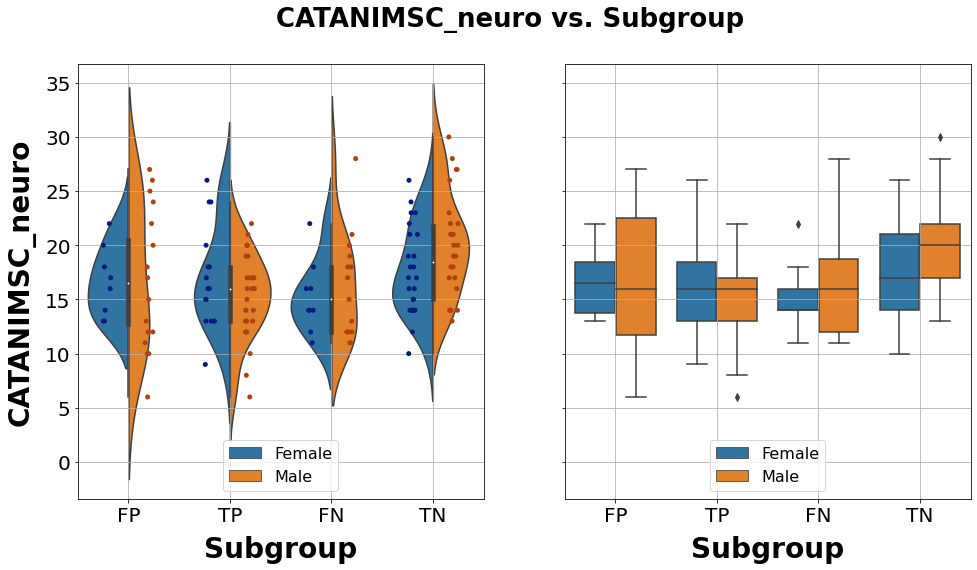

In [74]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='CATANIMSC_neuro', points=True)

In [75]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='AVDELTOT_neuro', points=True)

In [76]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='AGE', points=True)

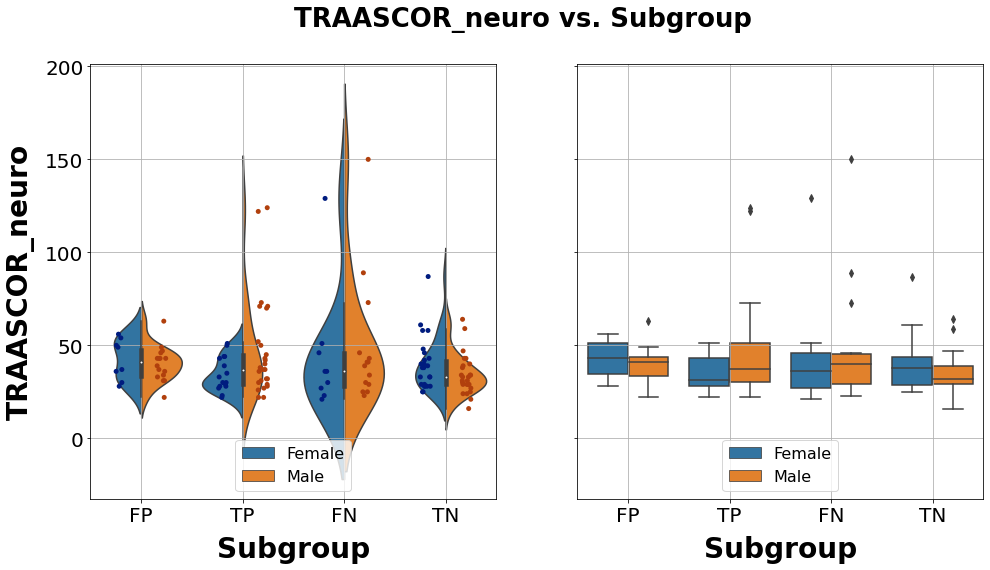

In [77]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='TRAASCOR_neuro', points=True)

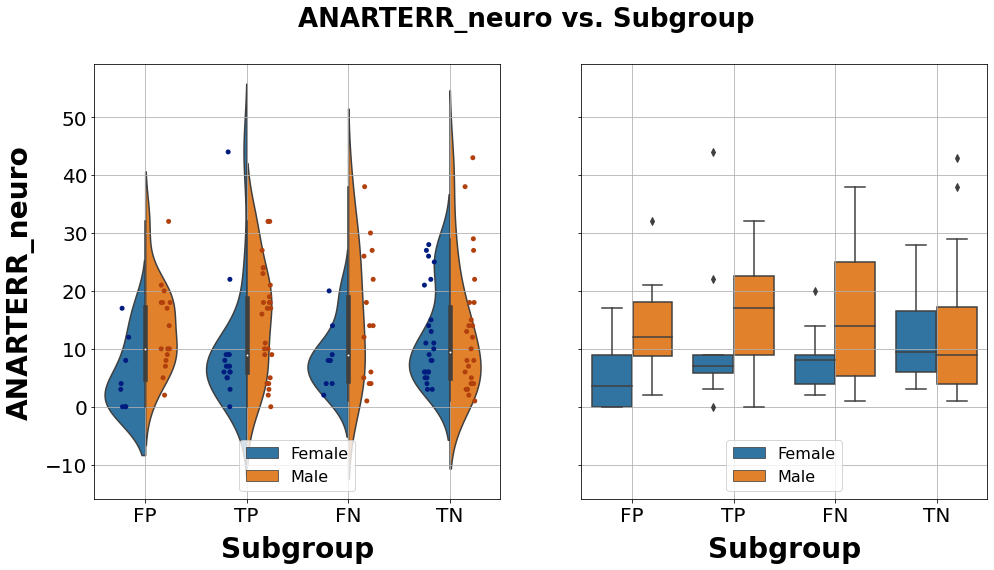

In [78]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='ANARTERR_neuro', points=True)

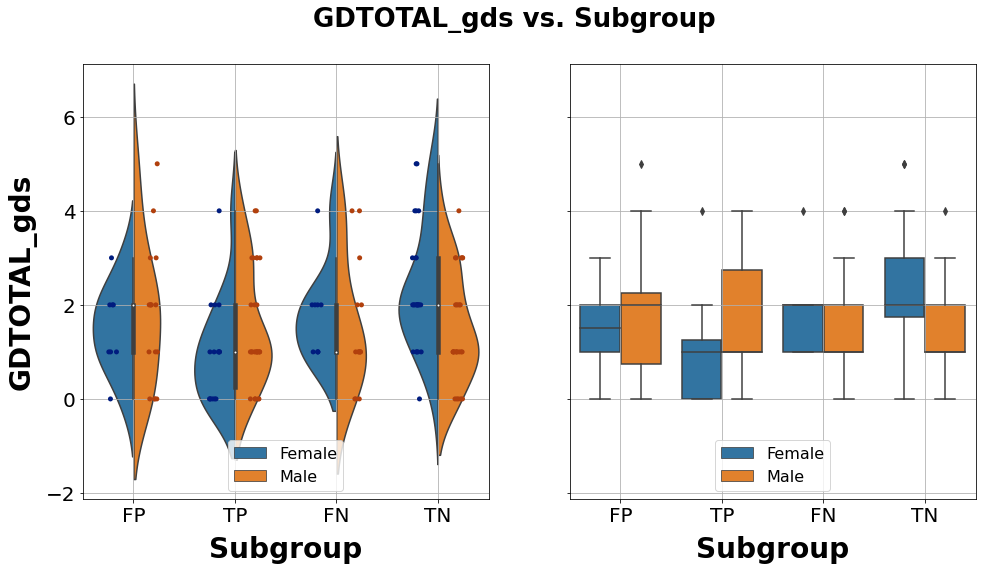

In [81]:
plot_violin_box_feature_vs_classification(predictions_bl, feature_name='GDTOTAL_gds', points=True)

In [ ]:
matplotlib.pyplot.bar(, height, width=0.8, bottom=None, *, align='center', data=None, **kwargs)

------

### Descriptive statistic for sMCI and cAD subgrup

AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  TRAASCOR_neuro  \
13    80.0             36.0               1.0             8.0            47.0   
26    76.8             27.0               5.0            10.0            61.0   
29    70.9             22.0               0.0             0.0            18.0   
37    72.8             29.0               1.0             8.0            40.0   
55    77.6             30.0               2.0            14.0           150.0   
...    ...              ...               ...             ...             ...   
6280  64.6             37.0               7.0            15.0            23.0   
6296  76.5             35.0               3.0            12.0            60.0   
6300  70.5             37.0              10.0            15.0            41.0   
6316  79.7             48.0              12.0            15.0            50.0   
6322  61.6             40.0               6.0             9.0            59.0   

      TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  ANARTERR_neuro  \
13             139.0             16.0          1.0             4.0   
26             300.0             19.0          4.0            23.0   
29             145.0             18.0          2.0            12.0   
37             101.0             17.0          1.0             6.0   
55             300.0             12.0          0.0             9.0   
...              ...              ...          ...             ...   
6280            85.0             24.0          1.0             9.0   
6296           250.0             11.0          3.0             5.0   
6300           136.0             15.0          1.0            13.0   
6316           156.0             21.0          1.0            14.0   
6322            98.0             22.0          2.0            10.0   

      LRHHC_n_long  Apoe4_  Gender_num_  Subgroup_num_  
13        0.003458     0.0            1              1  
26        0.005251     0.0            0              0  
29        0.003026     1.0            1              1  
37        0.002767     0.0            0              1  
55        0.002814     0.0            0              1  
...            ...     ...          ...            ...  
6280      0.005365     0.0            0              0  
6296      0.004281     0.0            0              0  
6300      0.005601     1.0            1              1  
6316      0.005228     1.0            0              0  
6322      0.005651     1.0            1              0  

[539 rows x 13 columns]

In [92]:
pwd

'/home/ingrid/123/src'

In [93]:
Xy_train = pd.read_csv('../results/20211111/3.12_Xy_train.csv')

In [94]:
Xy_train.head()

Unnamed: 0   AGE  RAVLT_immediate  AVDEL30MIN_neuro  AVDELTOT_neuro  \
0          13  80.0             36.0               1.0             8.0   
1          26  76.8             27.0               5.0            10.0   
2          29  70.9             22.0               0.0             0.0   
3          37  72.8             29.0               1.0             8.0   
4          55  77.6             30.0               2.0            14.0   

   TRAASCOR_neuro  TRABSCOR_neuro  CATANIMSC_neuro  GDTOTAL_gds  \
0            47.0           139.0             16.0          1.0   
1            61.0           300.0             19.0          4.0   
2            18.0           145.0             18.0          2.0   
3            40.0           101.0             17.0          1.0   
4           150.0           300.0             12.0          0.0   

   ANARTERR_neuro  LRHHC_n_long  Apoe4_  Gender_num_  Subgroup_num_  
0             4.0      0.003458     0.0            1              1  
1            23.0      0.005251     0.0            0              0  
2            12.0      0.003026     1.0            1              1  
3             6.0      0.002767     0.0            0              1  
4             9.0      0.002814     0.0            0              1